# Imports & General Settings


##### General imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

##### Model imports


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoLarsIC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from pygam import LinearGAM, s, l, te


from xgboost import XGBRegressor

from catboost import CatBoostRegressor

##### Specific imports


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import tree
from scipy.stats import shapiro, t
from mmdfuse import mmdfuse
from jax import random

##### General Settings


In [4]:
train = pd.read_csv('data/wine_train.csv', index_col=0)
test = pd.read_csv('data/wine_test.csv', index_col=0)

In [5]:
seed = 42

# The Data


## Data Overview


The purpose of this section is to provide an initial look at the data and ensure that the dataset does not contain duplicates or missing values.

In [6]:
train.head(3)

fixed acidity  volatile acidity  citric acid  residual sugar  \
wine_ID                                                                 
2137               7.2              0.16         0.26             7.1   
2652               7.3              0.22         0.31             2.3   
1544               8.9              0.13         0.49             1.0   

         chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
wine_ID                                                                        
2137         0.054                 41.0                 224.0  0.99660  3.38   
2652         0.018                 45.0                  80.0  0.98936  3.06   
1544         0.028                  6.0                  24.0  0.99260  2.91   

         sulphates  alcohol  wine_type  target  
wine_ID                                         
2137          0.55     10.1          0       5  
2652          0.34     12.9          0       7  
1544          0.32      9.9          0       5

In [7]:
train.shape

(4547, 13)

The shape of the train dataset is consistent with the one provided in the Kaggle description.

In [8]:
print('The dataset has a duplicate row :' , not train.index.duplicated().sum()==0)

The dataset has a duplicate row : False


In [9]:
print('The dataset has a missing values :' , train.isnull().sum().sum()>0)

The dataset has a missing values : False


The dataset looks consistent and it does not require to be $cleaned$

## Exploratory Data Analysis


To enhance the interpretation and results of our models, we need to construct them with a complete comprehensive understanding of the raw data. The aim of this section is therefore to acquire this understanding.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4547 entries, 2137 to 2732
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4547 non-null   float64
 1   volatile acidity      4547 non-null   float64
 2   citric acid           4547 non-null   float64
 3   residual sugar        4547 non-null   float64
 4   chlorides             4547 non-null   float64
 5   free sulfur dioxide   4547 non-null   float64
 6   total sulfur dioxide  4547 non-null   float64
 7   density               4547 non-null   float64
 8   pH                    4547 non-null   float64
 9   sulphates             4547 non-null   float64
 10  alcohol               4547 non-null   float64
 11  wine_type             4547 non-null   int64  
 12  target                4547 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 626.4 KB


In [11]:
train.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4547.000000       4547.000000  4547.000000     4547.000000   
mean        7.235364          0.340110     0.318155        5.367572   
std         1.319966          0.166643     0.142942        4.748314   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        2.900000   
75%         7.700000          0.400000     0.390000        8.000000   
max        15.600000          1.580000     1.000000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4547.000000          4547.000000           4547.000000  4547.000000   
mean      0.056112            30.364416            115.502309     0.994700   
std       0.035236            17.868751             56.989343     0.003015   
min       0.012000             1.000000              6.000000     0.987130   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994800   
75%       0.065000            41.000000            156.000000     0.997000   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol    wine_type       target  
count  4547.000000  4547.000000  4547.000000  4547.000000  4547.000000  
mean      3.219477     0.533006    10.496162     0.249835     5.824060  
std       0.163511     0.150728     1.179564     0.432965     0.876346  
min       2.740000     0.220000     8.000000     0.000000     3.000000  
25%       3.110000     0.430000     9.500000     0.000000     5.000000  
50%       3.210000     0.510000    10.300000     0.000000     6.000000  
75%       3.320000     0.600000    11.300000     0.000000     6.000000  
max       4.010000     2.000000    14.200000     1.000000     9.000000

Firstly, we notice that the target is coded as an integer due to the discrete nature of the wine ratings. Although the labels are discrete, we approach this problem as a regression task because of the inherent order of the ratings.

Furthermore, we observe that wine ratings range from a minimum of 3 to a maximum of 9. All covariates are continuous, except for the `wine_type` feature. This binary covariate represents red wine as 0 and white wine as 1.

During the exploratory analysis, we will visualize the distribution of these two wine types using different colors. This will help us determine if both wines follow similar distributions, in which case we can train a common predictor. However, if the distributions differ significantly, we will consider training separate predictors for each wine type.

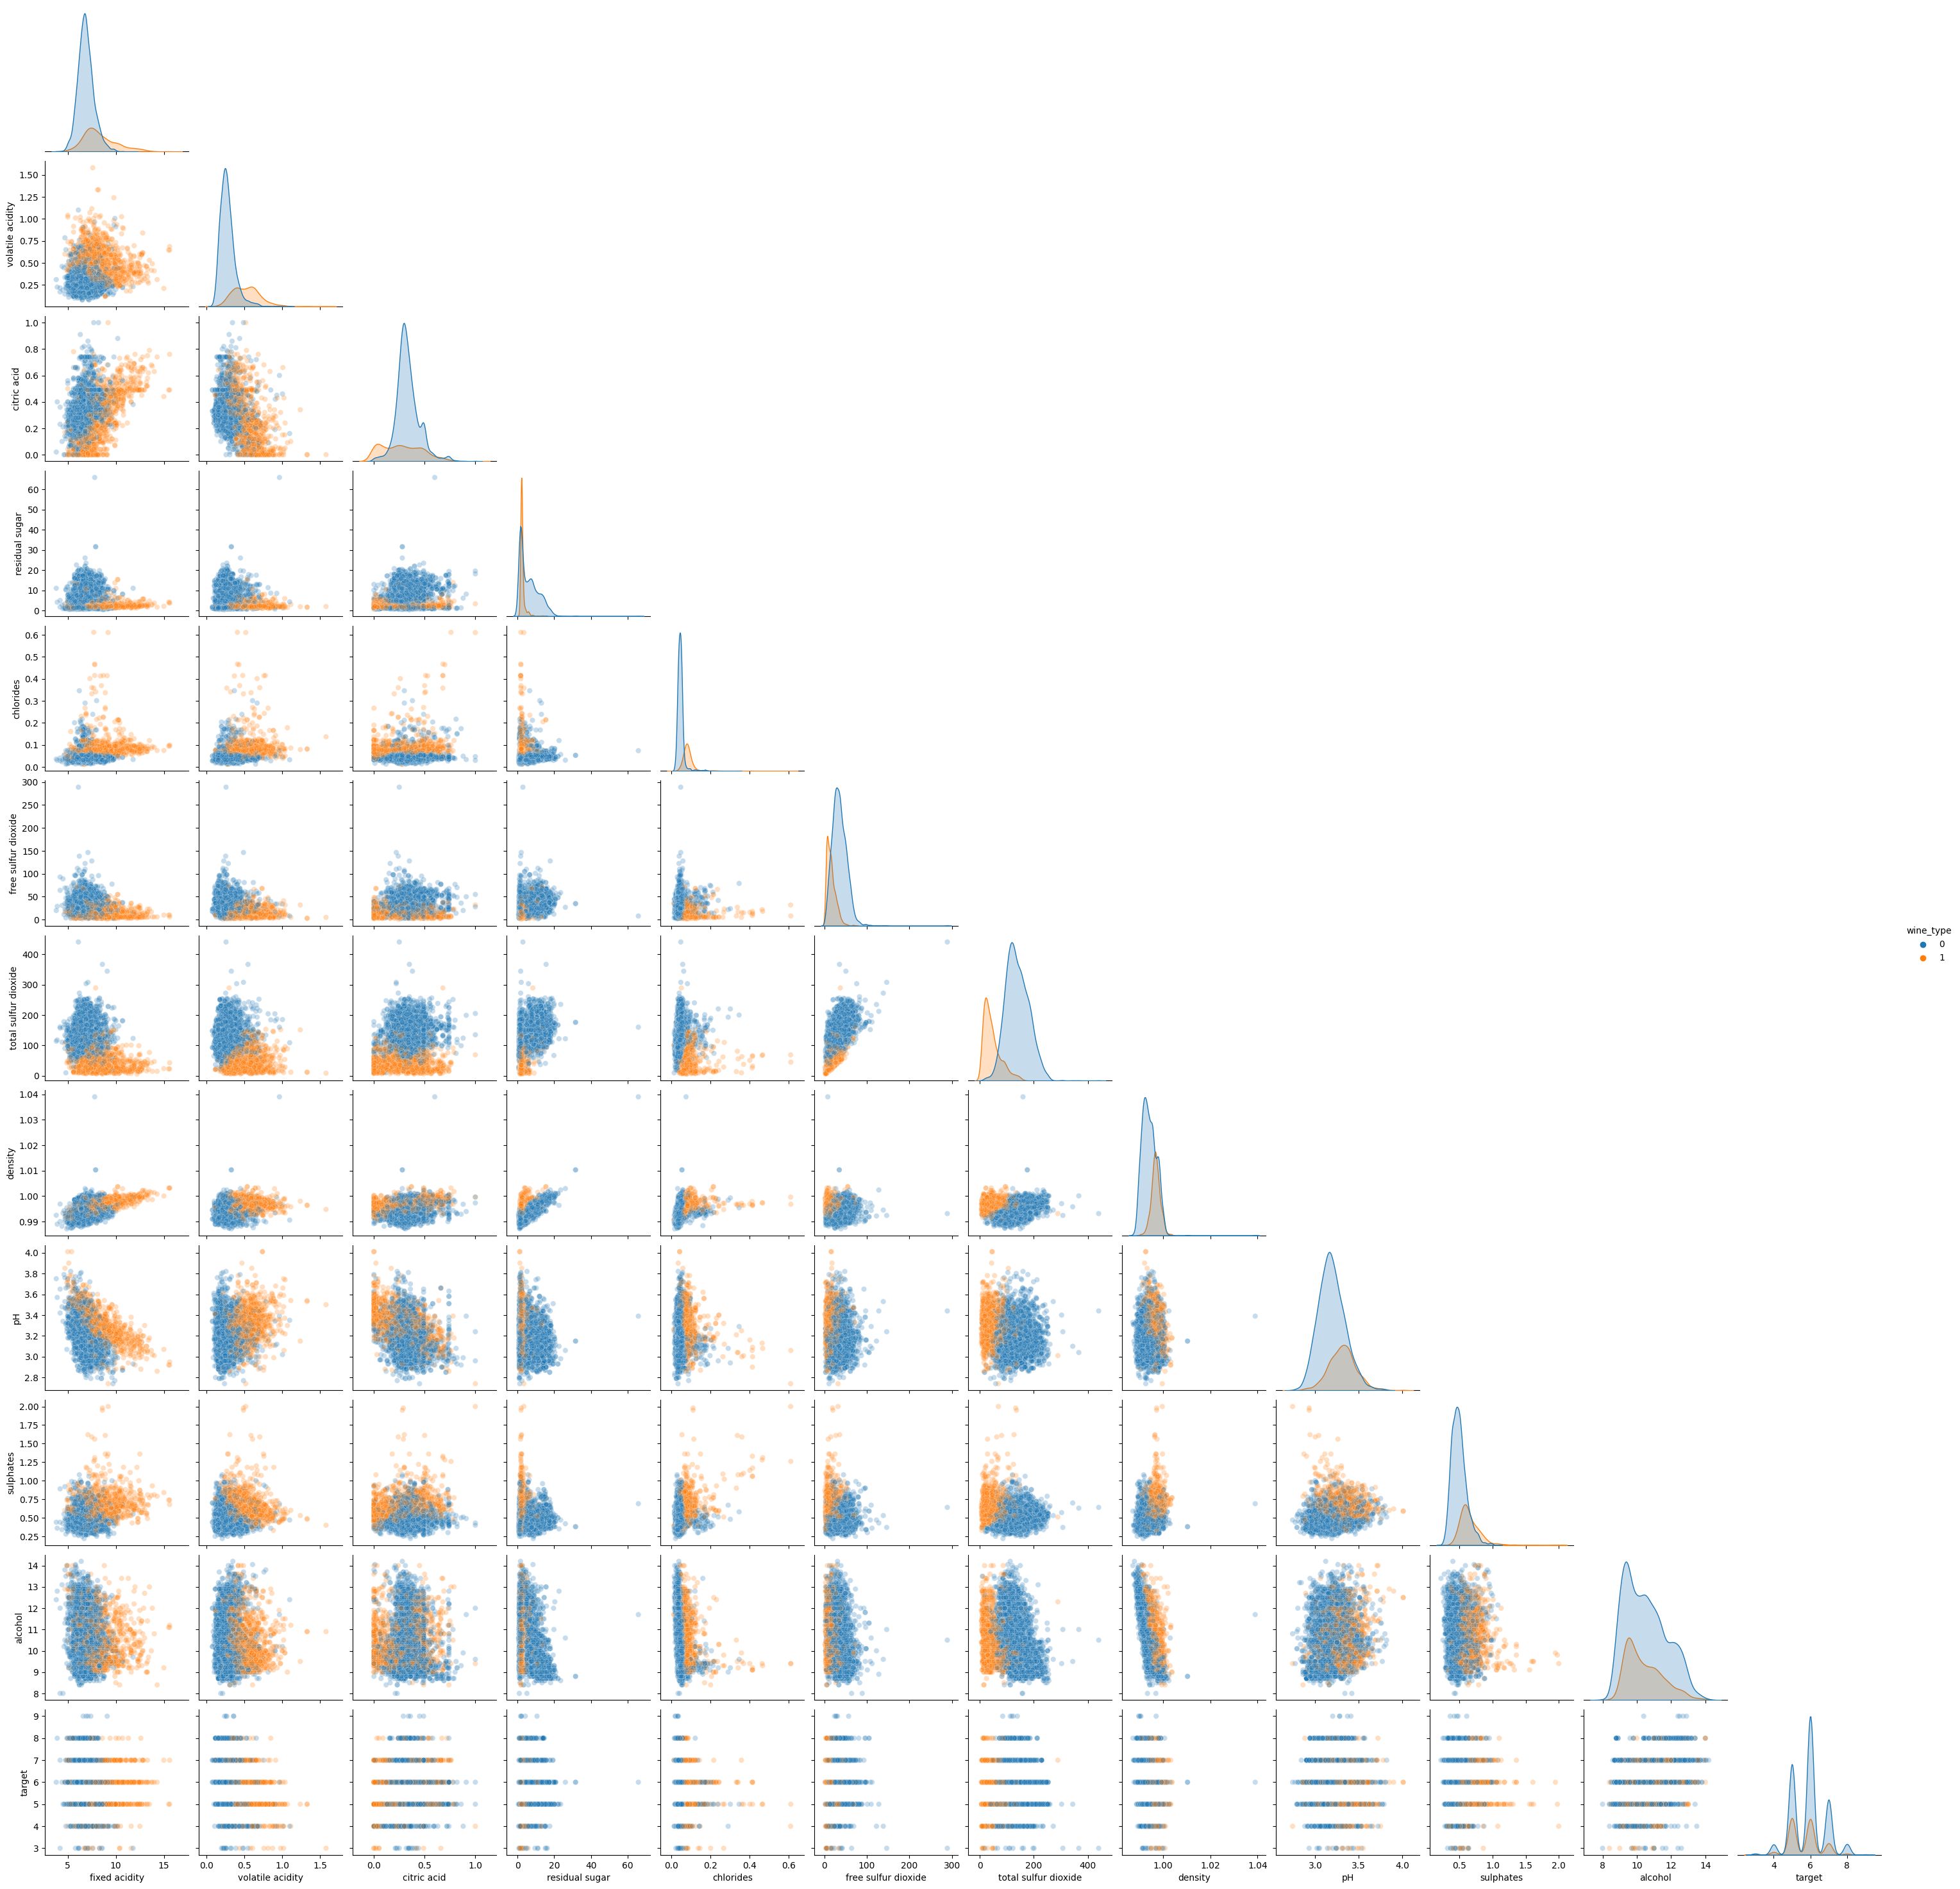

In [12]:
sns.pairplot(train, hue = 'wine_type', plot_kws={"alpha": 0.25}, corner=True) #plot_kws={"alpha": 0.25} to make the scatteur point more transparent

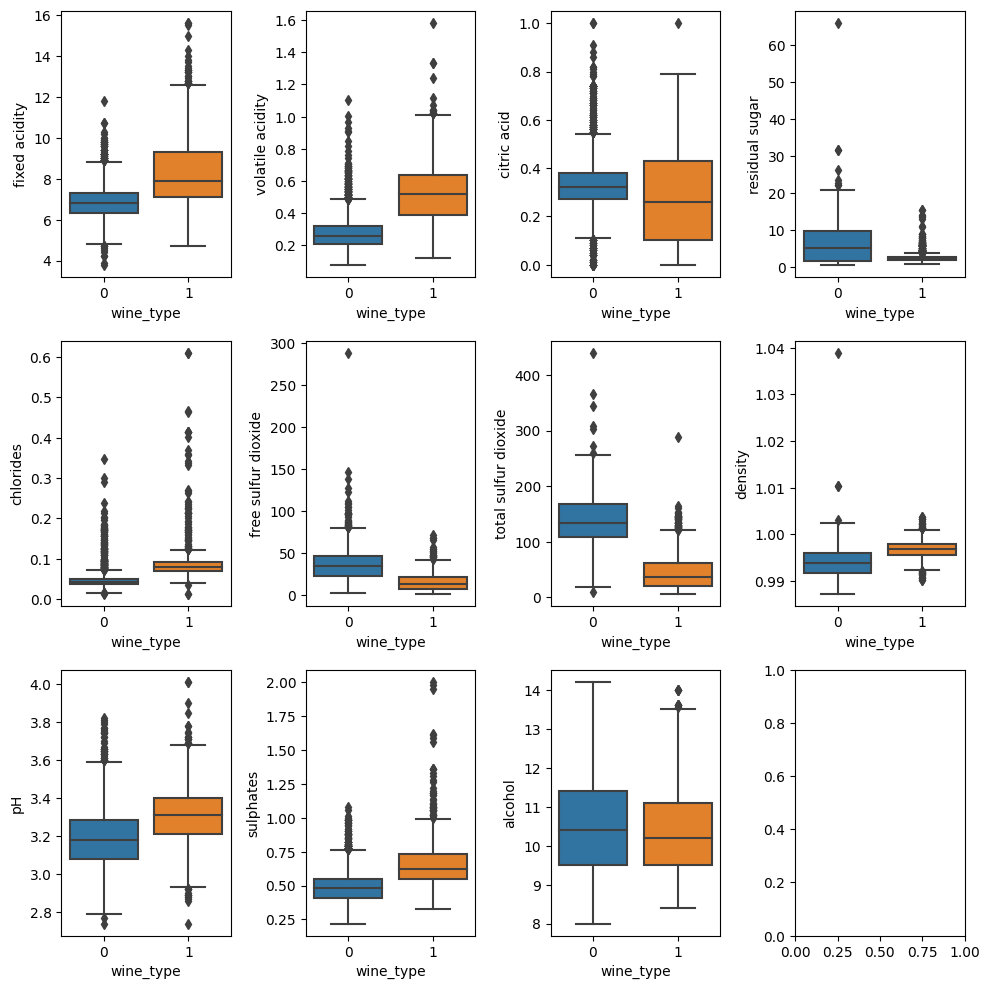

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(len(train.columns[:-2])):
    sns.boxplot(data=train, y=train.columns[i], x='wine_type', ax=axes[i])
plt.tight_layout()
plt.show()

From the last two plots, a notable divergence between both wine types is evident. The pairplot distinctly showcases different patterns for each. For example, when comparing citric acid against fixed acidity, the orange points representing white wine (type 1) exhibit a slope closer to the identity line, while the blue points, representing red wine (type 0), align parallel to the citric acid axis. Moreover, when observing pH against fixed acidity, the blue points form a linear pattern, whereas the orange points show a more quadratic relationship.

Furthermore, the boxplot analysis reveals significant shifts in certain variables, such as sulphates, and differences in the concentration of the boxes in others, like residual sugars.

However, before considering the separation of both types, it is crucial to verify the feasibility of doing so—ensuring we have adequate data for each to train a specific model.

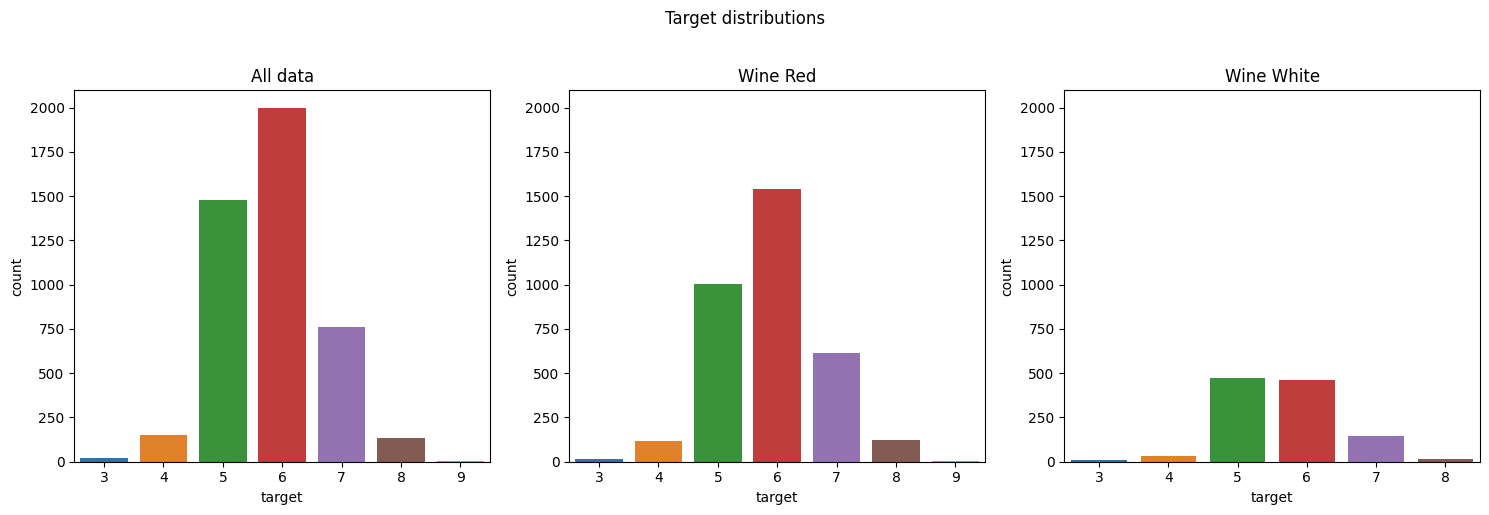

There is 3411 red wine row in the dataset, i.e 0.75%
There is 1136 white wine row in the dataset, i.e 0.25%


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
max_count = max(train['target'].value_counts().max(),
                train[train['wine_type']==0]['target'].value_counts().max(),
                train[train['wine_type']==1]['target'].value_counts().max()) +100
for ax in axes:
    ax.set_ylim(0, max_count)
sns.countplot(data=train, x='target', ax=axes[0])
axes[0].set_title('All data')
sns.countplot(data=train[train['wine_type']==0], x='target', ax=axes[1])
axes[1].set_title('Wine Red')
sns.countplot(data=train[train['wine_type']==1], x='target', ax=axes[2])
axes[2].set_title('Wine White')
plt.suptitle('Target distributions', y=1.02)
plt.tight_layout()
plt.show()
print(f'There is {train.wine_type.value_counts()[0]} red wine row in the dataset, i.e {(train.wine_type.value_counts()[0]/train.shape[0]):.2f}%')
print(f'There is {train.wine_type.value_counts()[1]} white wine row in the dataset, i.e {(train.wine_type.value_counts()[1]/train.shape[0]):.2f}%')

More formally, we can provide a mathematical foundation for these intuitions. The objective of Two-sample testing is to assess the null hypothesis that the two samples are drawn from the same distribution, as opposed to following different distributions.

To avoid the typical issue of splitting the data for kernel training and testing in the kernel-based statistic of MMD, we will use the MMD-FUSE. This method, in fact, avoids the necessity of dividing the dataset into halves for kernel training and testing.


This test was recently implemented by Antonin Schrab on his github : https://github.com/antoninschrab/mmdfuse-paper

In [15]:
res = mmdfuse(train[train.wine_type == 0].drop(['wine_type', 'target'], axis=1).values, train[train.wine_type == 1].drop(['wine_type', 'target'], axis=1).values, random.PRNGKey(seed))
if res==1:
    print('The test of equality of distributions between red and white wine is rejected')
else:
    print('The test of equality of distributions between red and white wine is not rejected')

The test of equality of distributions between red and white wine is rejected


Observing the test results, it rejects the assumption that the samples follow the same distribution. This further supports the decision to consistently separate the white wine data from the red wine data.

In the sequel, our analysis and estimations will be conducted separately for each type of wine. They will be combined only at the submission stage.

Therefore, we start by an specific data exploration for each wine type:

### Red Wine


We plot a correlation map highlighting only the extreme values to improve overall visibility.

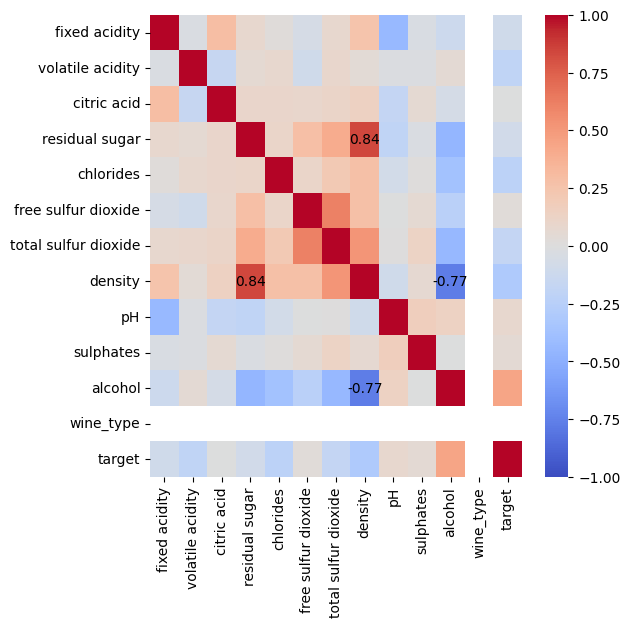

In [16]:
plt.figure(figsize=(6, 6))
correlation_matrix = train[train.wine_type == 0].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            plt.text(j+0.5, i+0.5, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center')
            plt.text(i+0.5, j+0.5, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center')

plt.show()

There is not a prevailing high correlation across the covariates. However, we do notice a strong correlation between (`density`,`residual_sugar`), and a significant negative correlation between (`density`,`alcohol`).

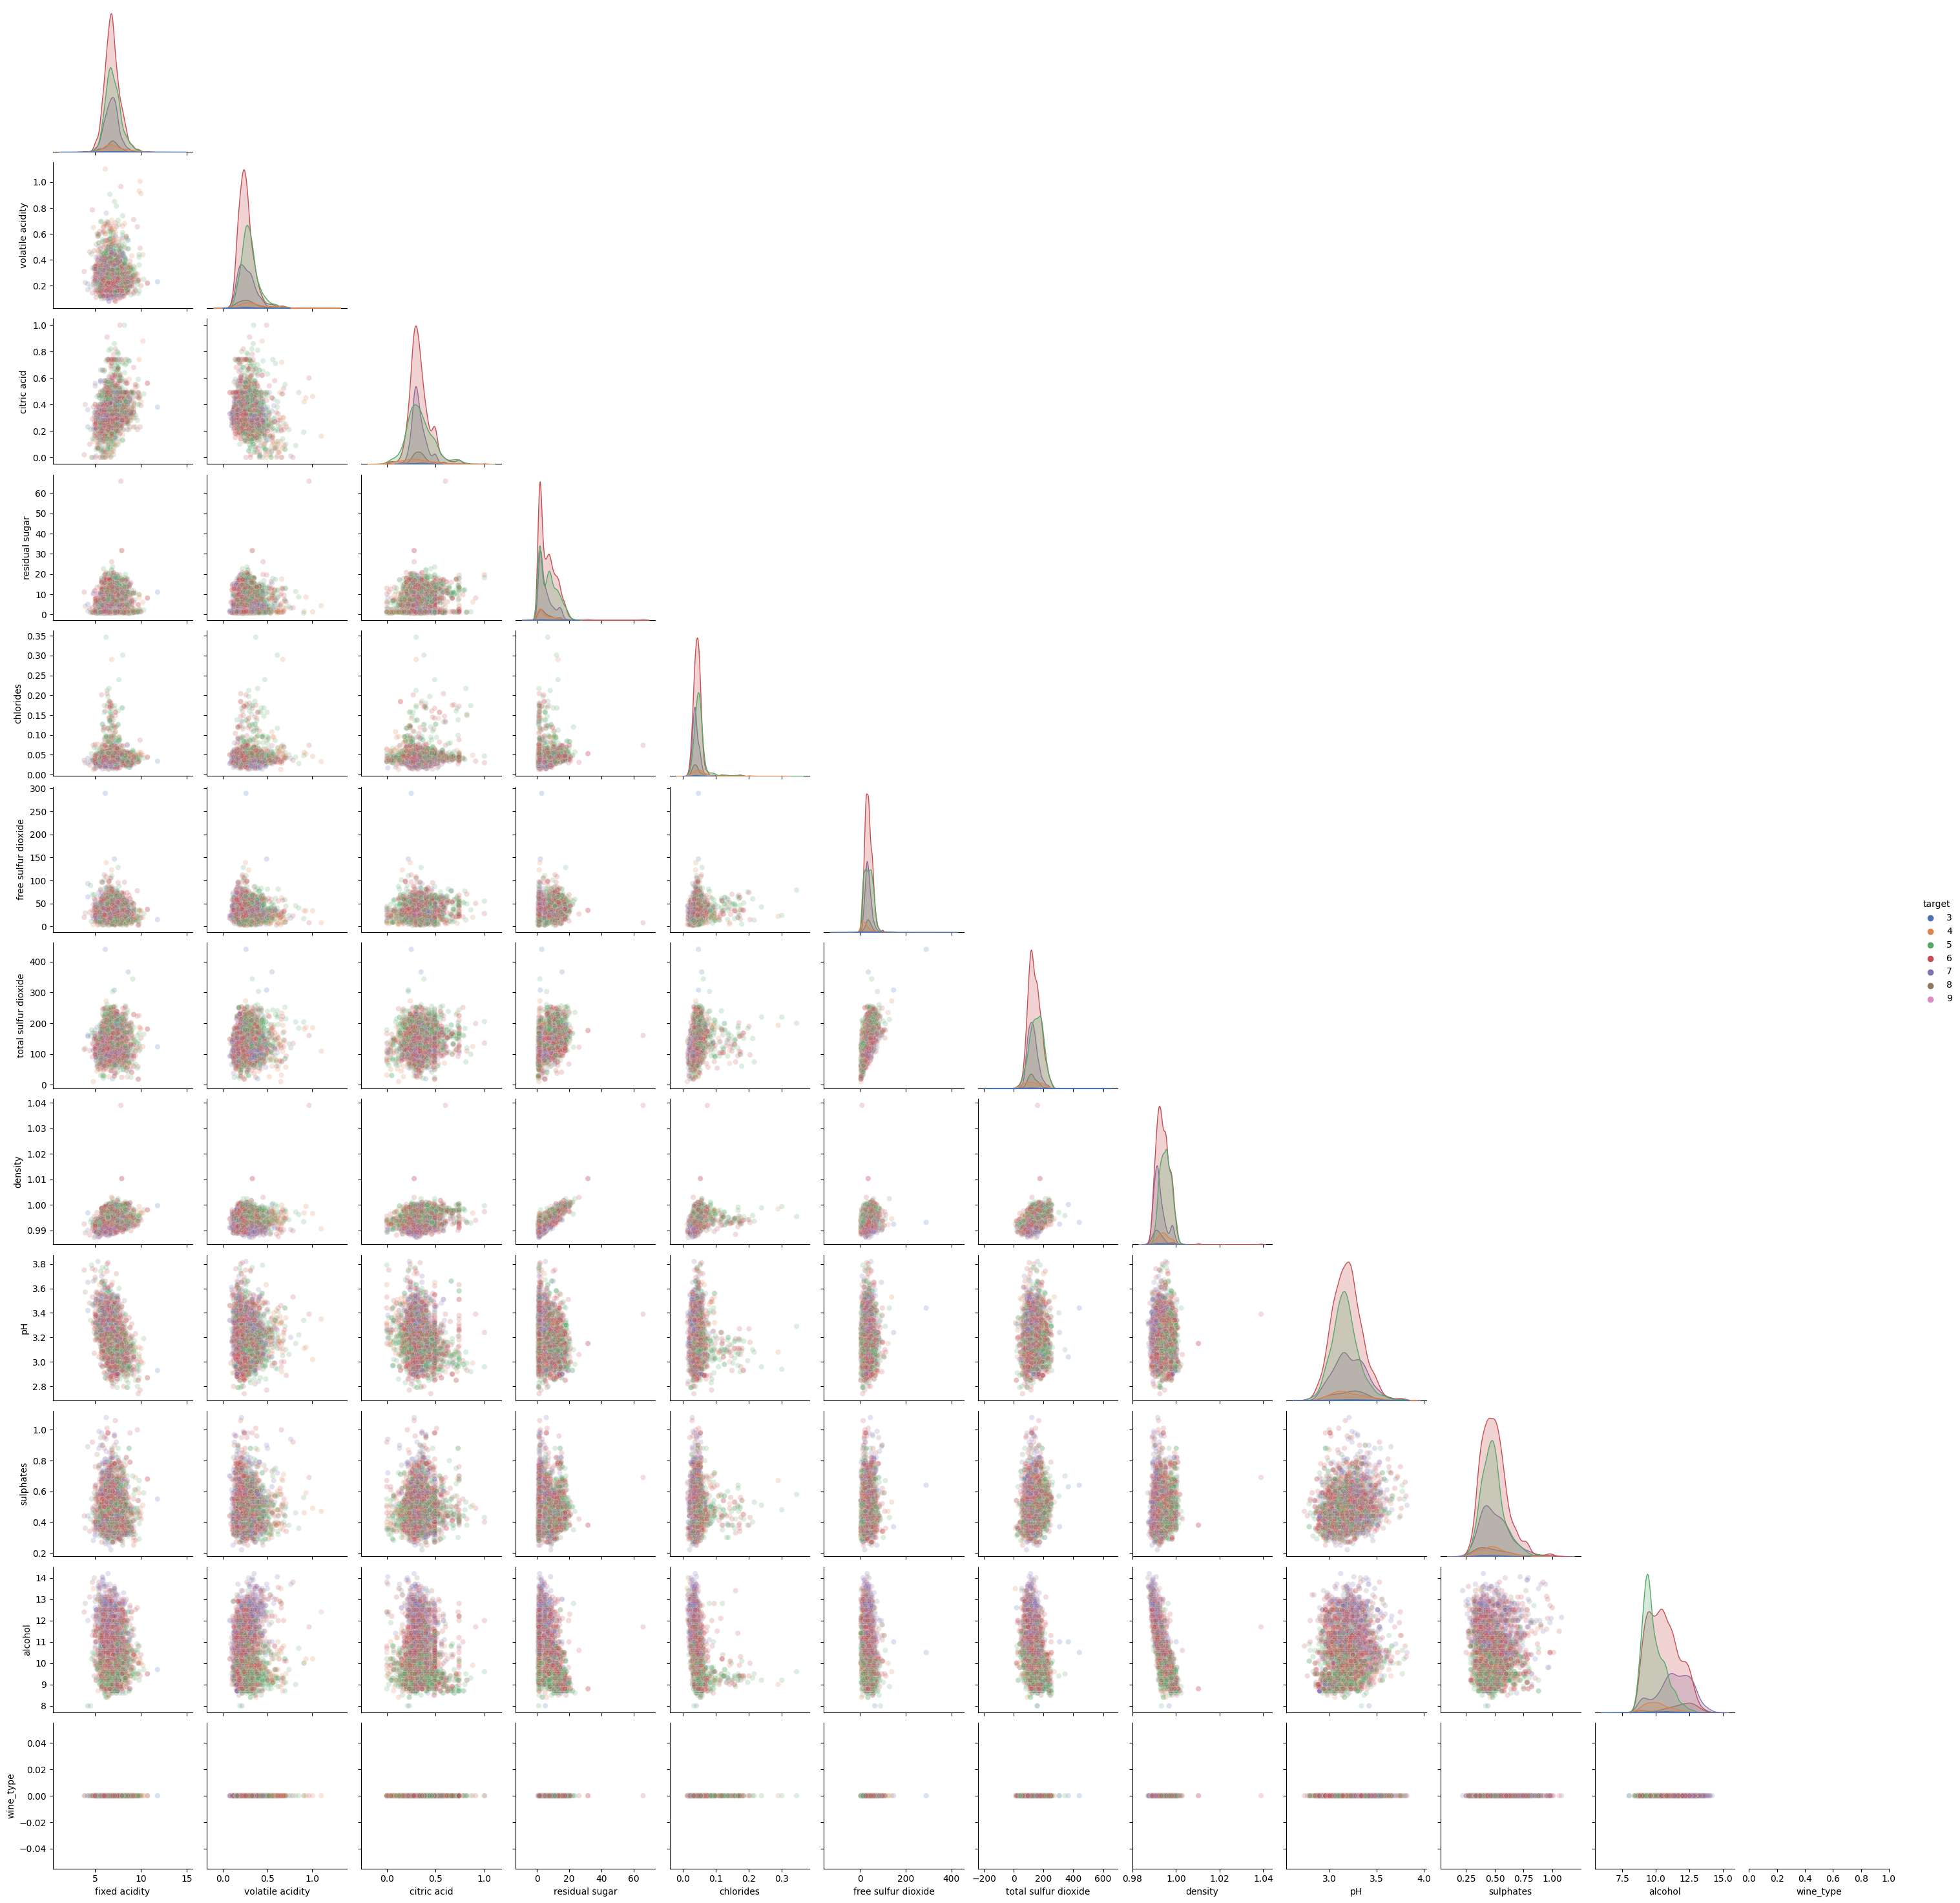

In [17]:
sns.pairplot(train[train.wine_type==0], hue = 'target', palette='deep', plot_kws={"alpha": 0.20}, corner=True)

We observe numerous distinct patterns in the relationships among the covariates, color-shaded by the labeling. These observations enable us to identify interactions between the covariates, such as the linear decrease of alcohol with density. Such insights could be particularly valuable, for instance, in the application of the GAM model, as detailed later.

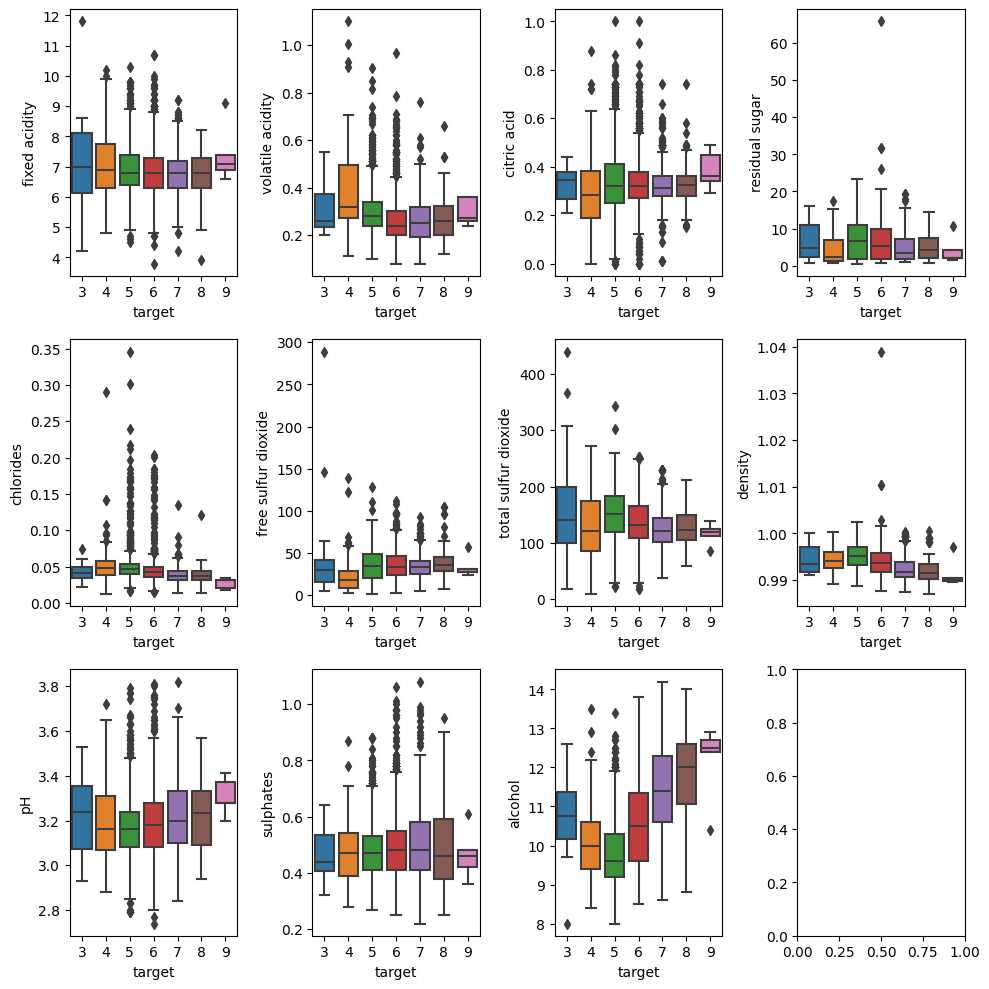

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(len(train.columns[:-2])):
    sns.boxplot(data=train[train.wine_type==0], y=train.columns[i], x='target', ax=axes[i])
plt.tight_layout()
plt.show()

We observe an interesting effect with `alcohol`. Wines rated as $mean$ (with a score of 5) tend to improve as alcohol content increases. Contrarily, on the other tail, as alcohol content increases, the quality diminishes. A similar pattern is observed with pH, and the inverse relationship with density. Consequently, for predictive purposes, combining covariates in various ways will be essential to enhance accuracy.

### White wine


We plot a correlation map highlighting only the extreme values to improve overall visibility.

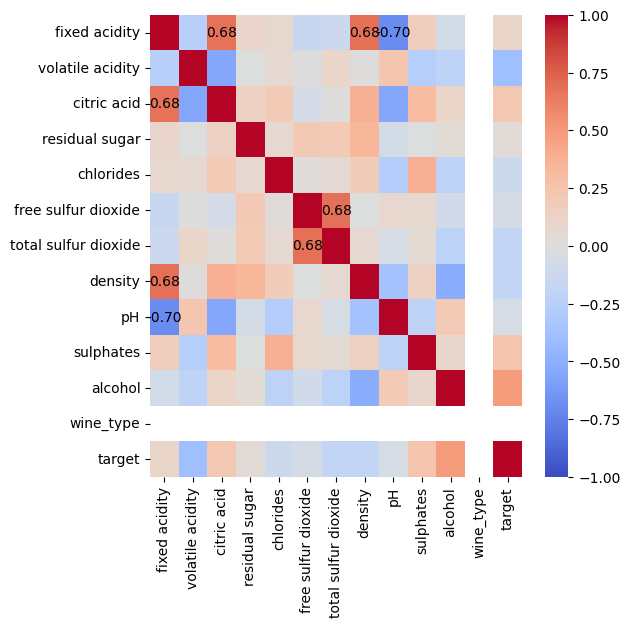

In [19]:
plt.figure(figsize=(6, 6))
correlation_matrix = train[train.wine_type == 1].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            plt.text(j+0.5, i+0.5, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center')
            plt.text(i+0.5, j+0.5, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center')

plt.show()

There is not a prevailing high correlation across the covariates. However, we do notice a strong correlation between (`density`,`residual_sugar`), and a significant negative correlation between (`density`,`alcohol`).

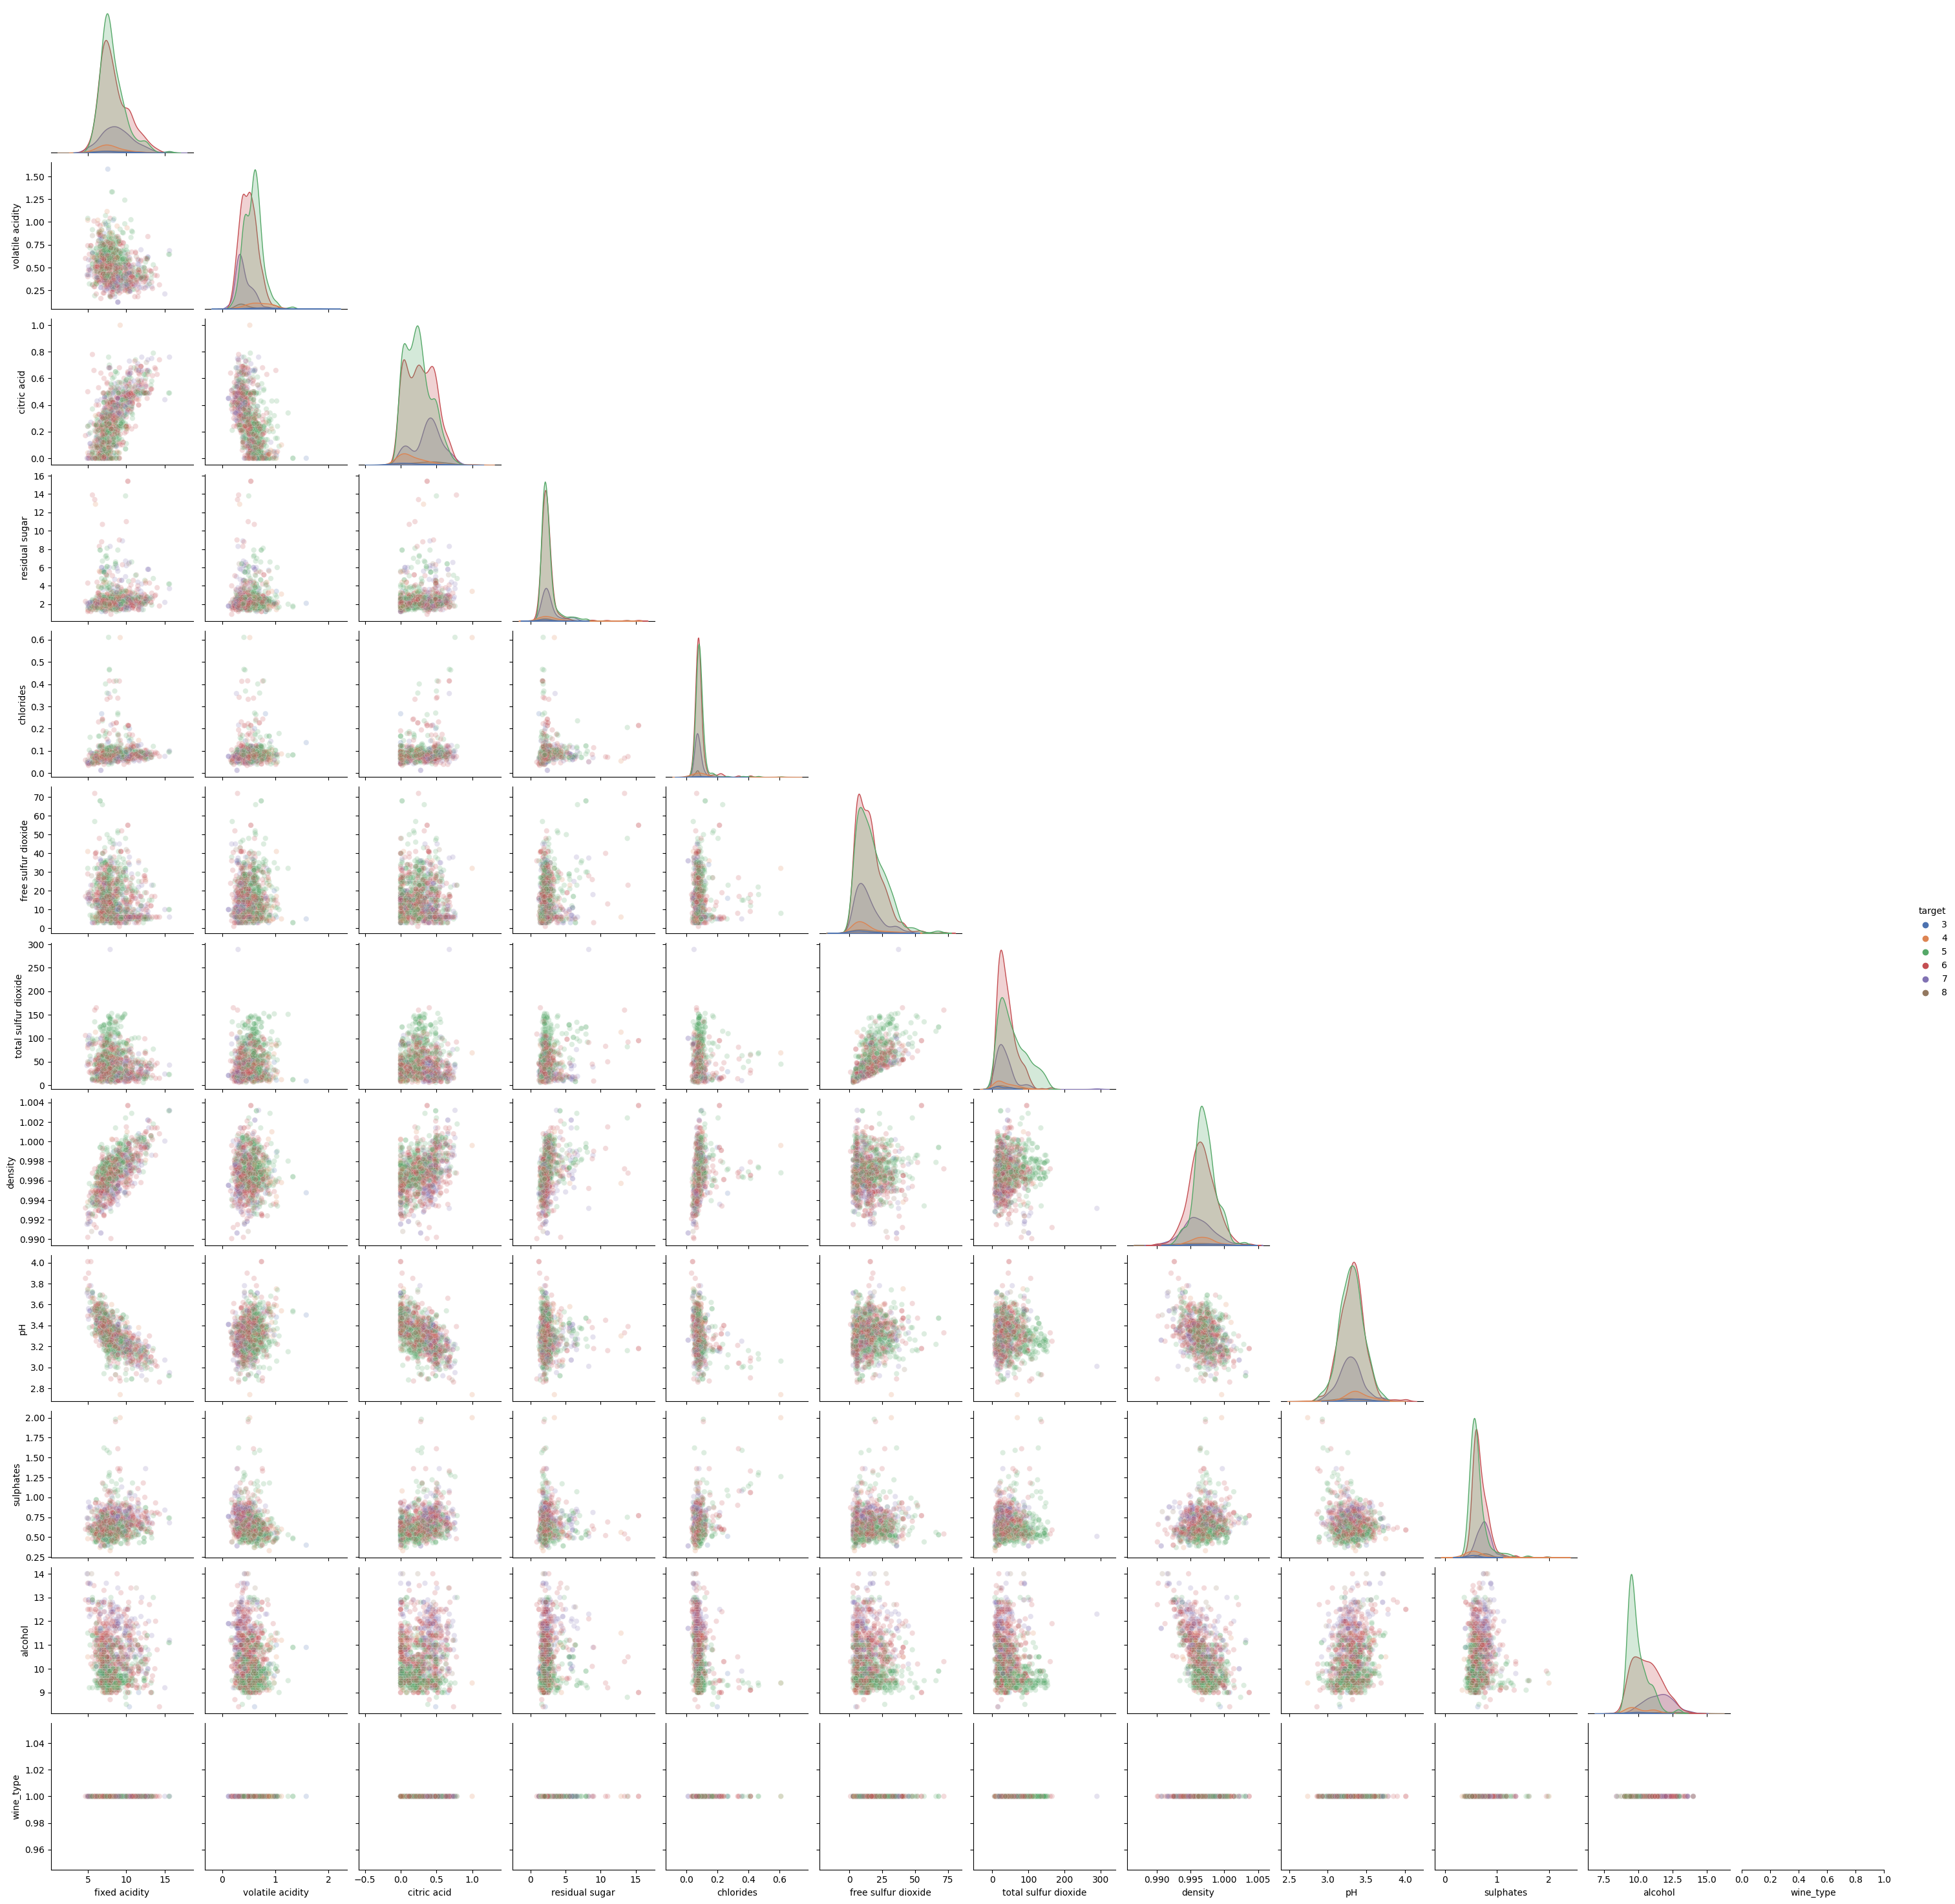

In [20]:
sns.pairplot(train[train.wine_type==1], hue = 'target', palette='deep', plot_kws={"alpha": 0.20}, corner=True)

From this plot we can visualize some relationships between the covariates. For instance, the quadratic relation between `pH` with respect to `fixed_acidity`, or the linear increase of density with `fixed_acidity`.

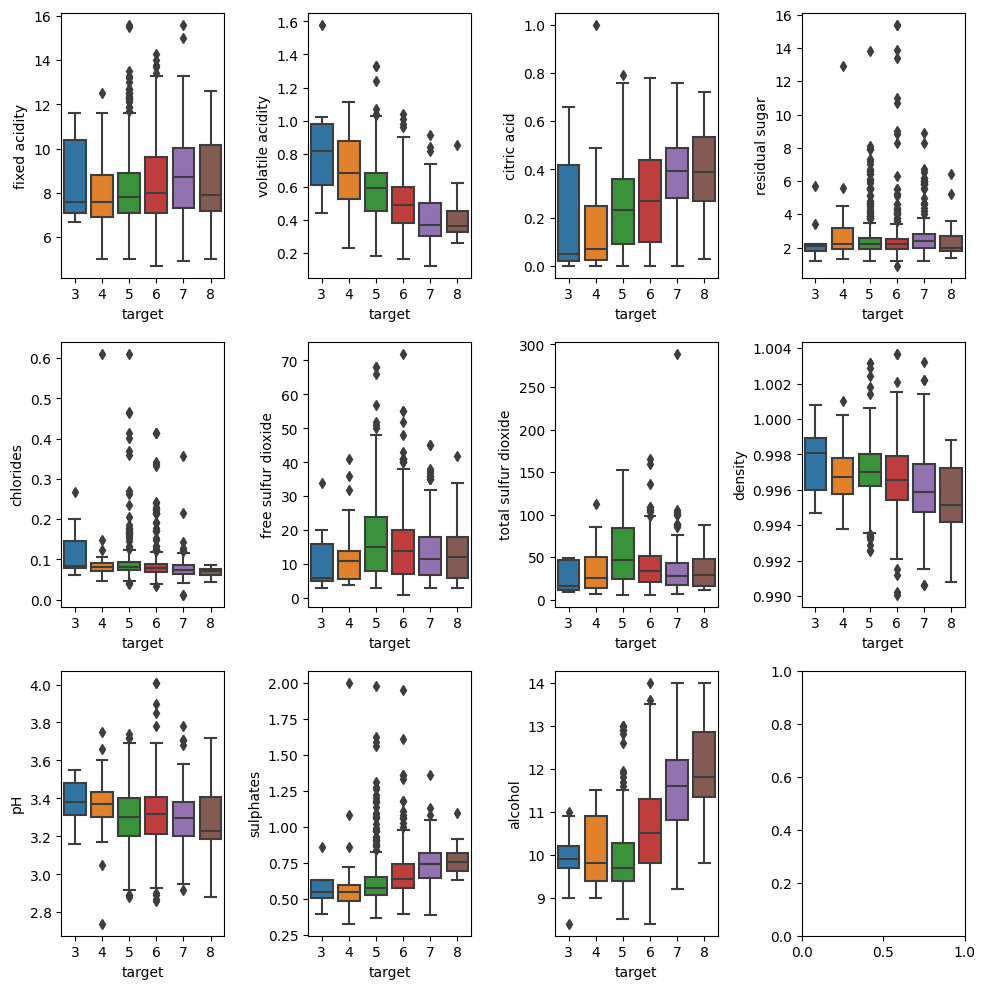

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(len(train.columns[:-2])):
    sns.boxplot(data=train[train.wine_type==1], y=train.columns[i], x='target', ax=axes[i])
plt.tight_layout()
plt.show()

We notice more apparent linear relationships, such as those observed with `volatile acidity` or `citric acid`. However, it is notable that these relationships are not entirely linear at the extremities. Hence, incorporating more complex relationships will be necessary to improve the accuracy.

## Data pre-processing & General Functions


As previously explained, we split up the dataset into two sub-datasets for each type of wine.


In [22]:
X_red = train[train.wine_type==0].drop(['wine_type', 'target'], axis=1)
y_red = train[train.wine_type==0]['target']

X_white = train[train.wine_type==1].drop(['wine_type', 'target'], axis=1)
y_white = train[train.wine_type==1]['target']

In order not to be influenced by the different variable metrics, we rescale the data.

In [23]:
X_red = pd.DataFrame(StandardScaler().fit_transform(X_red), index=X_red.index, columns=X_red.columns)
X_white = pd.DataFrame(StandardScaler().fit_transform(X_white), index=X_white.index, columns=X_white.columns)

To select the most robust model parameters or to estimate the generalization error, we will define a cross-validation function. Moreover, this function will print the computed generalization error.

In [24]:
def CV(model, X, y, params, k_folds=10, seed=seed):
    """
    Perform cross-validation with hyperparameter tuning using GridSearck-folds.

    Args:
        model: The estimator or model to be tuned.
        X: Feature matrix.
        y: Target vector.
        params: Dictionary of hyperparameters to be tuned.
        cv: Number of cross-validation folds (default is 10).
        seed: Seed for reproducibility (default is seed constant).

    Returns:
        grid: The fitted GridSearchCV object.
    """
    try:
        model.set_params(random_state=seed)
    except:
        warnings.warn("Random seed could not be set.", category=Warning)
    
    grid = GridSearchCV(model, param_grid=params, cv=k_folds, scoring='r2', n_jobs=-1, verbose=1)
    grid.fit(X, y)

    if len(params) == 1 and len(list(params.values())[0]) > 1 and type(list(params.values())[0][0]) in [int, float]:
        plt.figure(figsize=(6, 4))
        plt.plot(params[list(params.keys())[0]], grid.cv_results_['mean_test_score'], marker='o')
        plt.xlabel(list(params.keys())[0])
        plt.ylabel('R²')
        plt.title(f'GridSearchCV for {model.__class__.__name__}')
        plt.show()

    print(f'Best R² score is \033[91m{grid.best_score_:.3f}\033[0m for {grid.best_params_}')
    return grid

**Remark** : To minimize compiling time, you can find a parameter grid preceding each use of the function, indicating the primary set on which cross-validation has been executed. Additionally, there is another grid embedded within the first one to ensure a reasonable compiling time.

# Linear Regression


We are going to start from this ordinary least squares Linear Regression. It is based on the following minimization problem: 
$$\widehat \beta \in \underset{\beta \in \mathbb R ^{p+1}}{argmin} \left\|Y-X'\beta\right\|^2,$$
where $X'$ represents the augmented covariate space to accommodate the intercaept, and 
$p+1$ stands for the number of covariates plus one for the intercept. In our case, 
$p=11$ as we have 11 covariates accounting for the displayed wine type.

In the sequel we are going to omit this distinction with the intercept to lighten the notation, but it will always be included.

### Red wine


In [25]:
linear_red = CV(LinearRegression(), X_red, y_red, params={'fit_intercept': [True]})

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.273 for {'fit_intercept': True}


#### White wine


In [26]:
linear_white = CV(LinearRegression(), X_white, y_white, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.339 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


### Global Dataset


In [27]:
linear = CV(LinearRegression(), train.drop(['wine_type', 'target'], axis=1), train['target'], params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.294 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


As a simple test to verify the appropriateness of splitting the data into each wine type, we can confirm that implementing a linear regression over the global dataset resulted in a lower accuracy.

## Expansion of the covariate space

As outlined in the data exploration section, achieving a model with greater proximity to real data demands more flexibility than a linear approach. A preliminary strategy involves expanding the covariate space to allow for second-order interactions among the covariates. This expansion involves multiplying each column of the dataset with every other column. Consequently, this process yields an expanded covariate space of size $p$ (representing the initial space) plus $\sum_{i=1}^pi$ (the sum of interactions among the covariates). In our case, this expansion results in $11+\frac{11*12}{2}=77$ covariates.

In [28]:
def multipleVariables2by2(wine):
    X_input = wine.copy()
    X_output = pd.DataFrame()
    for i in range(len(X_input.columns)):
        for j in range(i, len(X_input.columns)):
            X_output[X_input.columns[i] + '_' + X_input.columns[j]] = X_input[X_input.columns[i]] * X_input[X_input.columns[j]]
    return pd.concat([wine, X_output], axis=1)

X_red_extend = multipleVariables2by2(X_red)
X_white_extend = multipleVariables2by2(X_white)
print(X_red_extend.shape)
print(X_white_extend.shape)

(3411, 77)
(1136, 77)


This expansion was conducted without an initial data-driven justification for each added variable, potentially introducing noise into the model. To address this, we will reduce the model complexity using penalization criteria to avoid the overfitting.

## Linear Regression with Lasso penalisation


The first penalizing method we are introducing is the standard Lasso regularization, which applies an $l^1$ penalization specifically designed for variable selection. It is associated with soft-thresholding and takes the following explicit form for linear regression:

$$\widehat \beta \in \underset{\beta \in \mathbb R ^p}{argmin} \|Y-X\beta\|^2+\lambda |\beta|_1$$


We notice that as the coefficient $\lambda$ increases, the penalty on the variables intensifies. Therefore, tuning the $\lambda$ parameter becomes crucial to control the regularization effect.

##### Least Angle Regression

**Remark** : Multiple approaches have been developped in order to compute this minimization. In this project, we opted for the Least Angle Regression (LARS, https://arxiv.org/pdf/math/0406456.pdf) because it is computationally just as fast as forward selection and it produces a full piecewise linear solution path, which is useful in cross-validation to tune the model.


$$
\text{Least Angle Regression (LARS) Algorithm}
$$

1. Start with all coefficients $\beta$ equal to zero.
2. Find the predictor $X_j$ most correlated with $y$.
3. Increase the coefficient $\beta_j$ in the direction of the sign of its correlation with $y$. Take residuals $r = y - \hat{y}$ along the way.
4. Stop when some other predictor $X_k$ has as much correlation with $r$ as $X_j$ has.
5. Increase $(\beta_j, \beta_k)$ in their joint least squares direction until some other predictor $X_m$ has as much correlation with the residual $r$.
6. Increase $(\beta_j, \beta_k, \beta_m)$ in their joint least squares direction until some other predictor $X_n$ has as much correlation with the residual $r$.
7. Continue until all predictors are in the model.


### Red Wine


In [29]:
params_LassoLARS_red = {
    'alpha' : np.linspace(0, 2, 1000)
}
params_LassoLARS_red = { 'alpha' : [0.004004004004004004]}

In [30]:
lassoLARS_grid_red = CV(LassoLars(), X_red_extend, y_red, params=params_LassoLARS_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.312 for {'alpha': 0.004004004004004004}


A significant limitation of the LASSO approach is the bias introduced by the penalization term. With its soft-thresholding, it drives the estimates toward zero, diminishing the estimates even for crucial covariates. One proposed solution is to use LASSO solely for selecting important covariates and then follow up with a standard linear regression using those selected variables. Alternative methods, such as the Adaptive Lasso or Gauss Lasso, could also have been considered.

In [31]:
lassoLARS_red = CV(LinearRegression(), X_red_extend[X_red_extend.columns[lassoLARS_grid_red.best_estimator_.coef_ != 0]], y_red, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.305 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


The interval of the hyperparameter $\lambda$ is chosen empirically. We initially test over a significantly large interval, then gradually narrow it down around the maximum value, repeating this process a few times.

##### Akaike Information Criterion (AIC) & Bayes Information Criterion (BIC)


Another standard criterion for model selection involves AIC and BIC. AIC is derived from frequentist probability, while BIC is grounded in Bayesian probability. The penalty term incorporated by AIC is smaller than that of BIC, rendering it more conservative and more open to accepting complex models.

We have enough data to avoid AICcorrection and as the data is not high-dimensional, we can guarantee the asymptotic efficiency of the BIC criterion.


In [32]:
lassoAIC_grid_red = CV(LassoLarsIC(criterion='aic'), X_red_extend, y_red, params={'fit_intercept' : [True]})
lassoAIC_red = CV(LinearRegression(), X_red_extend[X_red_extend.columns[lassoAIC_grid_red.best_estimator_.coef_ != 0]], y_red, params={'fit_intercept': [True]})

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.312 for {'fit_intercept': True}
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.312 for {'fit_intercept': True}


In [33]:
lassoBIC_grid_red = CV(LassoLarsIC(criterion='bic'), X_red_extend, y_red, params={'fit_intercept' : [True]})
lassoBIC_red = CV(LinearRegression(), X_red_extend[X_red_extend.columns[lassoBIC_grid_red.best_estimator_.coef_ != 0]], y_red, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.285 for {'fit_intercept': True}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.306 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


### White Wine


##### Least Angle Regression


In [34]:
params_LassoLARS_white = {
    'alpha' : np.linspace(0, 2, 1000)
}
params_LassoLARS_white = { 'alpha' : [0.016016016016016016]}

In [35]:
lassoLARS_grid_white = CV(LassoLars(), X_white_extend, y_white, params=params_LassoLARS_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.349 for {'alpha': 0.016016016016016016}


In [36]:
lassoLARS_white = CV(LinearRegression(), X_white_extend[X_white_extend.columns[lassoLARS_grid_white.best_estimator_.coef_ != 0]], y_white, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.347 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


##### Akaike Information Criterion (AIC) & Bayes Information Criterion (BIC)


In [37]:
lassoAIC_grid_white = CV(LassoLarsIC(criterion='aic'), X_white_extend, y_white, params={'fit_intercept' : [True]})
lassoAIC_white = CV(LinearRegression(), X_white_extend[X_white_extend.columns[lassoAIC_grid_white.best_estimator_.coef_ != 0]], y_white, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.343 for {'fit_intercept': True}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.348 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


In [38]:
lassoBIC_grid_white = CV(LassoLarsIC(criterion='bic'), X_white_extend, y_white, params={'fit_intercept' : [True]})
lassoBIC_white = CV(LinearRegression(), X_white_extend[X_white_extend.columns[lassoBIC_grid_white.best_estimator_.coef_ != 0]], y_white, params={'fit_intercept': [True]})

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.330 for {'fit_intercept': True}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.350 for {'fit_intercept': True}


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


However, we do not notice a substantial difference compared to the previous model without the covariate expansions. This lack of significant change is due to the fact, as previously stated, that the covariate space has not been expanded based on a data-driven criterion focusing on specific interactions to introduce into the model. To address this, we introduce the Generalized Additive Model (GAM), which offers enhanced expressiveness for capturing interactions.

# Generalized Additive Models (GAM)


GAMs are smooth semi-parametric models, similar to Generalized Linear Models(GLM), incorporating a link function $g$ and additivity. However, they are more versatile as they permit non-linear functions of features. 

As our aim is regression, the link function $g$ we will use is the identity.

In practice, we will use the PyGAM library, which uses spline `s(.)` and tensor spline `te(.,.)` functions to find polynomial interpetrations of a variable or the tensor product of two variables.
In order to have $g \equiv Id$, we will use the `LinearGAM(.)` function of the library.

While this method offers the advantage of capturing intricate high-degree relationships between the covariates and the target, it comes with the drawback of significantly complicating model interpretation and not guaranteeing optimal model selection. The primary goal is to generate an interpretable model, even if it means sacrificing some performance.

Thanks to the model's additivity, we can assess the impact of each interaction by either adding or removing it. Hence, we will undertake an iterative manual procedure, beginning with a basic model and gradually incorporating feature functions. This process commences with the classic linear model:
$$\text{gam = LinearGAM}( l(1)+...+l(11))$$  
(we recall that we have 11 covariates).

Then, we try to find smooth functions. To do this, we refer to the boxplots of each variable. Whenever we see that the means of the boxplots follow a polynomial function, we try to add a spline function on the variable.

For example with this boxplot, we thought that adding a spline function on the alcohol variable would give us more information because it seems to follow a polynomial function, draw in red.

![GAM Spline Function](images\GAM_spline_function.png)

Following a data-driven methodology, we will include or remove splines or linear covariates based on their significance in the model.

For instance, if we replace the linear covariate $i$ for its spline version, 

$$\text{gam = LinearGAM( l(1)+...+l(i-1)+s(i)+l(i+1)+...+l(11) )}.$$

We aim to identify smooth interactions in the data by referencing pair plots. When observing a potential polynomial trend among data points, we introduce a tensor spline function to capture these interactions.

For instance, we note a visible pattern highlighted in red between the `pH` and `fixed_acidity` variables in a pair plot, which makes us consider incorporating a tensor spline between them to extract additional information.

![GAM Tensor Spline Function](images\GAM_tensor_spline_function.png)

Following a similar data-driven methodology, we will include or remove tensor splines or linear covariates or splines based on their significance in the model.

if we change the variable $i$ and add tensor spline on the $(i,j)$ and $(p,q)$ couples.
For instance, if we add a tensor spline on the $(i,j)$ and $(p,q)$ couples to the previous model with $\{i_0,...i_l\}\subset \{1,...,11\}$ linear interactions and $\{k_0,...k_s\}\subset \{1,...,11\}$ splines:
$$\text{gam = LinearGAM}( l(i_0)+...+l(i_l) +s(k_0)+...+s(k_s)+ te(i,j) +te(p,q) )$$


**Remark** : The LinearGAM function is cross-validated to find the ideal number of splines for functions, so we do not need to use the CV function. The default kernel is the normal one.


### Red Wine


In [39]:
gam_red = LinearGAM(s(0)+s(1)+s(5)+s(6)+s(7)+l(9)+te(0,7)+te(1,3)+ te(3,10)+te(4,7)+te(5,6)+te(1,2)+te(4,10)+te(10,7)+te(8,7)+te(8,4)).fit(X_red, y_red)
print(f'Best R² score is \033[91m{gam_red.score(X_red, y_red):.3f}\033[0m')
gam_red.summary()

Best R² score is 0.422
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    111.6625
Link Function:                     IdentityLink Log Likelihood:                                 -4069.0279
Number of Samples:                         3411 AIC:                                             8363.3806
                                                AICc:                                            8371.1478
                                                GCV:                                                0.4995
                                                Scale:                                              0.4701
                                                Pseudo R-Squared:                                    0.422
Feature Functi

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\1956519420.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_red.summary()


### White Wine


In [40]:
gam_white = LinearGAM(s(1)+s(2)+s(3)+s(6)+s(7)+s(9)+s(10)+te(0,2)+te(0,7)+te(0,8)+te(1,2)+te(7,10)).fit(X_white, y_white)
print(f'Best R² score is \033[91m{gam_white.score(X_white, y_white):.3f}\033[0m')
gam_white.summary()

Best R² score is 0.501
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    108.1937
Link Function:                     IdentityLink Log Likelihood:                                 -1302.3425
Number of Samples:                         1136 AIC:                                             2823.0724
                                                AICc:                                            2846.5319
                                                GCV:                                                0.4475
                                                Scale:                                              0.3715
                                                Pseudo R-Squared:                                   0.5014
Feature Functi

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\3694256918.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_white.summary()


The R² score are clearly superior to all other methods. This confirms that adding expressability to our model gives more information from the data.

Expanding our approach to capture other complex relations, we will explore the kernel trick applicable to SVR.

# Support Vector Regression (SVR)


We note that this method is an extension of the classification technique SVM. In essence, we adopt a similar principle of considering only a subset of the training data to form predictions. Just as the standard SVM focuses on points that are misclassified or near the margin to construct its margin, in this regression scenario, we consider only the subset of points where predictions deviate significantly from the true labels.

It finds a hyperplane that best matches the data points in a continuous space, while minimizing the prediction error $R^2$.
The SVR algorithm aims to find the hyperplane that passes through as many data points as possible within a certain distance to the margin. 

Like the standard SVM, kernels can be introduced to extend the feature space through mapping to a higher-dimensional space, enabling the construction of more expressive hyperplanes.

Additionally, similarly to the standard SVM, it incorporates the regularizing term $C$, where the regularization strength is inversely proportional to the parameter.

### Red Wine


In [41]:
params_SVR_red = {
    'C' : np.arange(1, 3, 0.2),
    'kernel' : ['linear', 'poly', 'rbf'],
    'gamma' : ['scale', 'auto'],
    'coef0' : [0,1,2],
    'degree' : [3, 4]
}
params_SVR_red = {'C': [2.1999999999999997], 'coef0': [0], 'gamma': ['scale'], 'kernel': ['rbf']}

In [42]:
svr_red = CV(SVR(), X_red, y_red, params=params_SVR_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.389 for {'C': 2.1999999999999997, 'coef0': 0, 'gamma': 'scale', 'kernel': 'rbf'}


### White Wine


In [43]:
params_SVR_white = {
    'C' : np.arange(1, 3, 0.2),
    'kernel' : ['linear', 'poly', 'rbf'],
    'gamma' : ['scale', 'auto'],
    'coef0' : [0,1,2],
    'degree' : [3,4]
}
params_SVR_white = {'C': [1.5999999999999999], 'coef0': [0], 'gamma': ['scale'], 'kernel': ['rbf']}

In [44]:
svr_white = CV(SVR(), X_white, y_white, params=params_SVR_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)


Best R² score is 0.379 for {'C': 1.5999999999999999, 'coef0': 0, 'gamma': 'scale', 'kernel': 'rbf'}


# Decision Tree


This method attempts to partition the space by posing binary questions, each on a single variable. We end up separating the covariate space $\mathcal{X}$ in $m$ regions given by $(R_1,... ,R_m)$. Then, the regressor is given by
$$ f(x) = \sum ^m_{j=1} v_j \mathbb{1}_{x\in R_j}. $$

Finding the optimal partition of the space is infeasible, thus multiple heuristic algorithms are proposed. Additionally, we must estimate the values $v_j$ which is done with the empirical mean restricted to the observations in the region.

It is highly flexible but faces the inconvenience of potentially interpolating the entire dataset. To manage this, we tested multiple parameters, like the minimum number of samples required to split a leaf or the maximum allowed depth.



### Red Wine


In [45]:
params_tree_red = {
    'criterion' : ["squared_error", "friedman_mse"],
    'splitter' : ["random", "best"],
    'max_depth' : list(np.arange(2,50,1)) + [None],
    'min_samples_leaf' : [1, 10, 100, 500, 1000],
    'max_features' : ["auto", "sqrt", "log2", None, 1]
}
params_tree_red = {'criterion': ['squared_error'], 'max_depth': [8], 'max_features': ['auto'], 'min_samples_leaf': [100], 'splitter': ['best']}

In [46]:
tree_red = CV(DecisionTreeRegressor(criterion='squared_error'), X_red, y_red, params=params_tree_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.299 for {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 100, 'splitter': 'best'}


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


### White Wine


In [47]:
params_tree_white = {
    'criterion' : ["squared_error", "friedman_mse"],
    'splitter' : ["random", "best"],
    'max_depth' : list(np.arange(2,50,1)) + [None],
    'min_samples_leaf' : [1, 10, 100, 500, 1000],
    'max_features' : ["auto", "sqrt", "log2", None, 1]
}
params_tree_white = {'criterion': ['squared_error'], 'max_depth': [5], 'max_features': ['auto'], 'min_samples_leaf': [10], 'splitter': ['best']}

In [48]:
tree_white = CV(DecisionTreeRegressor(criterion='squared_error'), X_white, y_white, params=params_tree_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.302 for {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'splitter': 'best'}


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


We are going to plot the variable importance and the representation of each Decision tree.

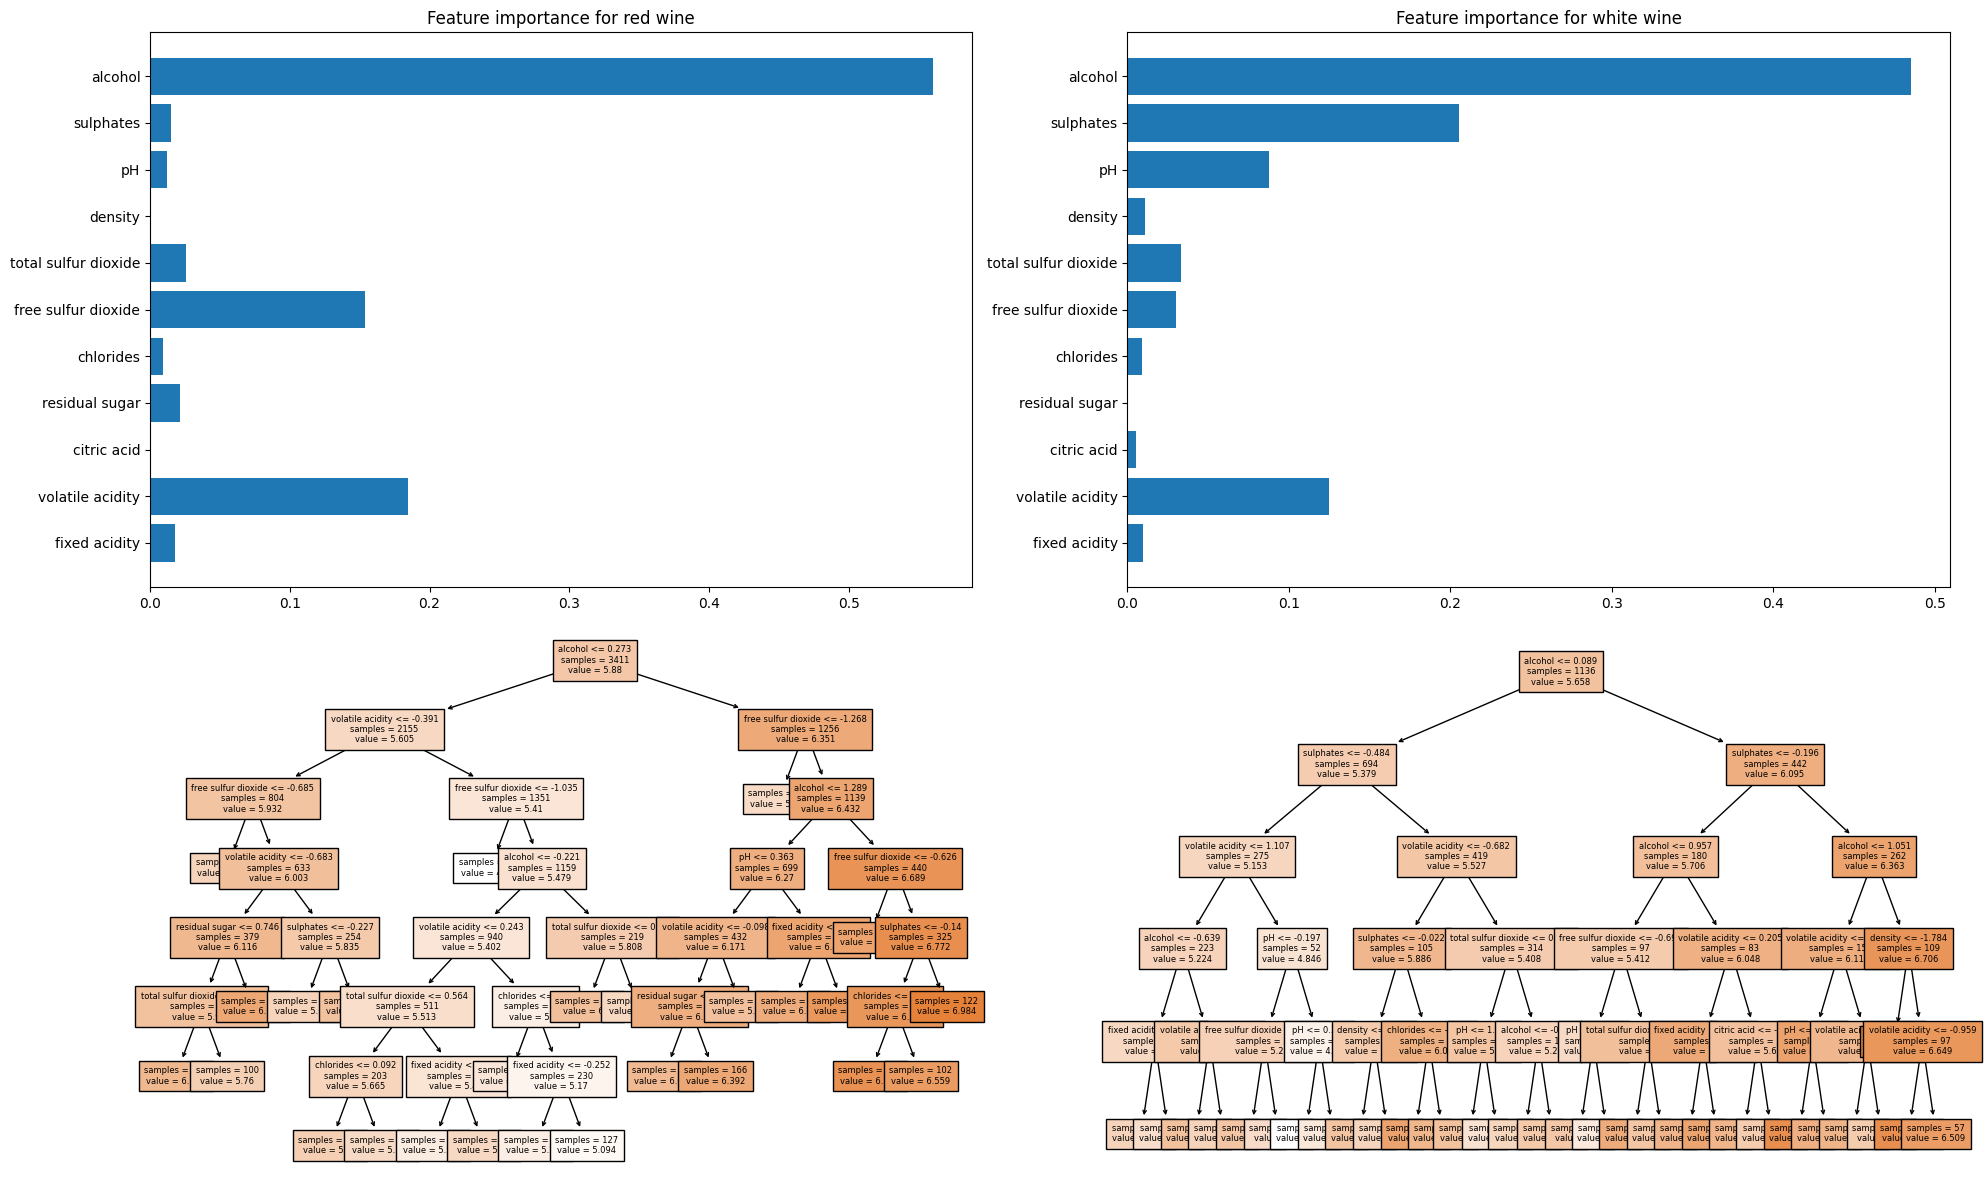

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes[0,0].barh(X_red.columns, tree_red.best_estimator_.feature_importances_)
axes[0,0].set_title('Feature importance for red wine')
axes[0,1].barh(X_white.columns, tree_white.best_estimator_.feature_importances_)
axes[0,1].set_title('Feature importance for white wine')
tree.plot_tree(tree_red.best_estimator_, ax=axes[1,0], fontsize=6, feature_names=X_red.columns, impurity=False, filled=True)
tree.plot_tree(tree_white.best_estimator_, ax=axes[1,1], fontsize=6, feature_names=X_white.columns, impurity=False, filled=True)
plt.tight_layout()
plt.show()

One covariate tends to concentrate the importance, resulting in underuse of other covariates. To address this, we aim to circumvent the issue by selecting only a subset of possible covariates at each split, enabling the extraction of information from all features. This will be done with the Random Forest.


Fitting 10 folds for each of 384 candidates, totalling 3840 fits
Best R² score is 0.287 for {'max_depth': 5, 'min_samples_split': 7}
Fitting 10 folds for each of 384 candidates, totalling 3840 fits
Best R² score is 0.289 for {'max_depth': 4, 'min_samples_split': 2}


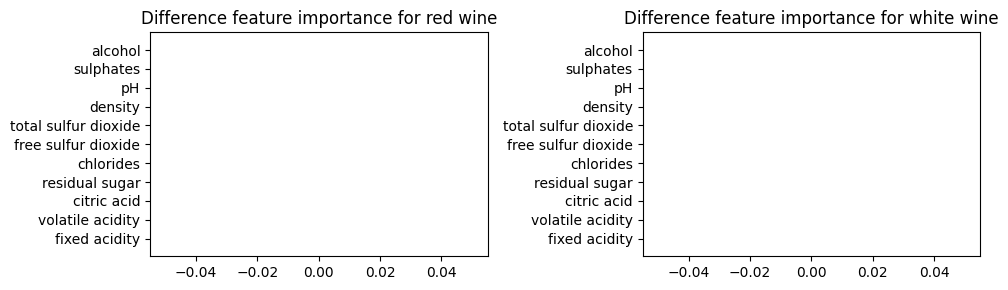

In [50]:
tree_red_bis = CV(DecisionTreeRegressor(criterion='squared_error'), X_red, y_red, params={'max_depth': range(2,50), 'min_samples_split': range(2,10)}, seed=420)
tree_white_bis = CV(DecisionTreeRegressor(criterion='squared_error'), X_white, y_white, params={'max_depth': range(2,50), 'min_samples_split': range(2,10)}, seed=420)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].barh(X_red.columns, tree_red.best_estimator_.feature_importances_ - tree_red.best_estimator_.feature_importances_)
axes[0].set_title('Difference feature importance for red wine')
axes[1].barh(X_white.columns, tree_white.best_estimator_.feature_importances_ - tree_white.best_estimator_.feature_importances_)
axes[1].set_title('Difference feature importance for white wine')
plt.tight_layout()
plt.show()

Despite the randomness of the data during cross-validation, the importance of the variables is identical. We therefore understand that these variables accumulate a great deal of information, leaving the others to appear as noise, diminishing the R² score. However, given the low score and low depth, we understand that the model is simply unable to extract information from these other variables. The predictor is therefore complacently biased by these few variables. Let's look back at the scores, they are still greater than zero, so the model is more efficient than the naive one. Thus, we could use the law of large numbers to harness the wisdom of crowds for prediction. To do this, we're going to use a new model: random forests.

A drawback of its flexibility is the significant stochastic error it induced. To address this, the bagging method aims to average out this error across multiple predictors constructed to be as uncorrelated as possible, introducing the Random Forest. 

# Random Forest


Random Forests is a bagging predictor that leverages the bootstrap technique, involving resampling the data with replacement to simulate new datasets. A decision tree is trained for each bootstrap sample. The final predictor is determined by averaging the individual predictors:
$$ \hat f _{bag}(\mathcal D_n)(x) = \frac{1}{n} \sum^b _{i=1}\hat f_i(x). $$
The primary advantage of this method is its reduction of variance while sustaining an equal level of bias. Another benefit is the diversity introduced not only by the data bootstrap but also by randomly sampling a subset of features for conducting splits. This method is parameterized by `max_features` to determine the size of the allowed covariates subset. In our scenario, the exclusion of certain features could potentially enable exploration of new space separations, potentially counterbalancing the drawbacks observed in our previous decision trees regarding bias and variance.

### Red Wine


In [51]:
params_RF_red = {
    'n_estimators': [100, 200,400,800,1500],
    'max_depth': range(17,24),
    'max_features': ['sqrt', 'log2']
}
params_RF_red = {'max_depth': [23], 'max_features': ['sqrt'], 'n_estimators': [700]}

In [52]:
rf_red = CV(RandomForestRegressor(criterion='squared_error'), X_red, y_red, params=params_RF_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.503 for {'max_depth': 23, 'max_features': 'sqrt', 'n_estimators': 700}


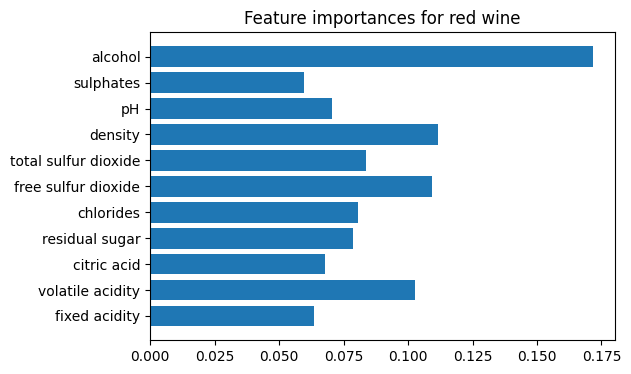

In [53]:
plt.figure(figsize=(6, 4))
plt.barh(X_red.columns, rf_red.best_estimator_.feature_importances_)
plt.title('Feature importances for red wine')
plt.show()

### White Wine


In [54]:
params_RF_white = {
    'n_estimators': [100, 200,400,800,1500],
    'max_depth': range(17,24),
    'max_features': ['sqrt', 'log2']
}
params_RF_white = {'max_depth': [19], 'max_features': ['sqrt'], 'n_estimators': [800]}

In [55]:
rf_white = CV(RandomForestRegressor(criterion='squared_error'), X_white, y_white, params=params_RF_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.464 for {'max_depth': 19, 'max_features': 'sqrt', 'n_estimators': 800}


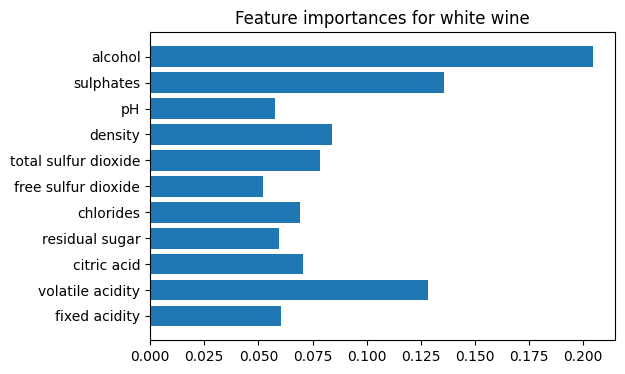

In [56]:
plt.figure(figsize=(6, 4))
plt.barh(X_white.columns, rf_white.best_estimator_.feature_importances_)
plt.title('Feature importances for white wine')
plt.show()

Random forests enabled a clear improvement in the R² score, particularly for red wine. Moreover, the feature importances were homogenized, giving us a less biased predictor. Here, we can rely on the importance of the variables, as sklearn uses MDI, which in our case is robust because none of the variables is categorical and the variables are only loosely correlated. As bagging seems to have been a good idea, we can now try another estimator based on the method of set.


# Gradient Boosting


It is an aggregation method, different from bagging, where the base predictors are not built in parallel and independently. Instead, they are constructed iteratively based on the residuals from previous iterations.

$$
\text{General Boosting Algorithm}
$$

1. Initialize with $\hat f_0 = 0 $
2. For each $m$ from $1$ to $M$, find $(\hat h _m, \hat \alpha _m) \in \underset{\alpha \in \mathbb R, h \in \mathcal F}{\mathrm{argmin}}\frac{1}{n}\sum _{i=1}^n c(\hat f_{m-1}(X_i)+\alpha h(X_i), Y_i)$ with $\hat f_{m-1}(X_i)=\sum _{k=1}^{m-1} \hat \alpha _k \hat h_k$.
3. Use the final predictor : $\hat f = \hat f _M = \sum _ {m=1}^M \hat h _m \hat \alpha _m$


In regression, the minimization step is too expensive, then an approach to solve it with a gradient step is proposed:


$$
\text{Gradient Boosting Algorithm}
$$

1. Initialize with $\hat f_0 = 0 $
2. For each $m$ from $1$ to $M$, find :

- $\delta_{m-1,i}=\left. -\frac{\partial c(f(X_i),Y_i)}{\partial f(X_i)} \right|_{f(X_i)=\hat f_{m-1}(X_i)}$

- then $\hat h_m \in \underset{m}{argmin}\frac{1}{n}\sum ^n_{i=1} c(h(X_i), \delta_{m-1,i})$

- and calculate $\hat f_m = \hat f_{m-1} + \alpha \hat h_m$ with $\alpha$ an arbitrary learning rate.

3. Use the final predictor : $\hat f = \hat f_M $


In our case, we'll be using two gradient boosting packages (`XGBoost` and `CatBoost`) which differ simply in their gradient descent optimization. They both use decision trees as a set of predictors, so let's go back to our first decision tree and see if it might be interesting to apply these packages by iterating a first-stage boosting algorithm.


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


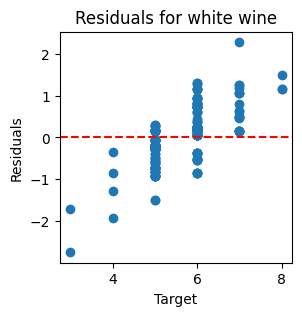

In [57]:
X_white_train, X_white_val, y_white_train, y_white_val = train_test_split(X_white, y_white, test_size=0.2, random_state=seed)
y_white_pred = tree_white.best_estimator_.fit(X_white_train, y_white_train).predict(X_white_val)
plt.figure(figsize=(3, 3))
plt.scatter(y_white_val, y_white_val - y_white_pred, marker="o")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Target')
plt.ylabel('Residuals')
plt.title('Residuals for white wine')
plt.show()

It is not surprising to see a linear form appear, as the decision tree is very shallow, making it similar to a naive estimator. However, we can deduce that it is possible to learn from these residuals, so let's verify this with a second learning process on them.

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


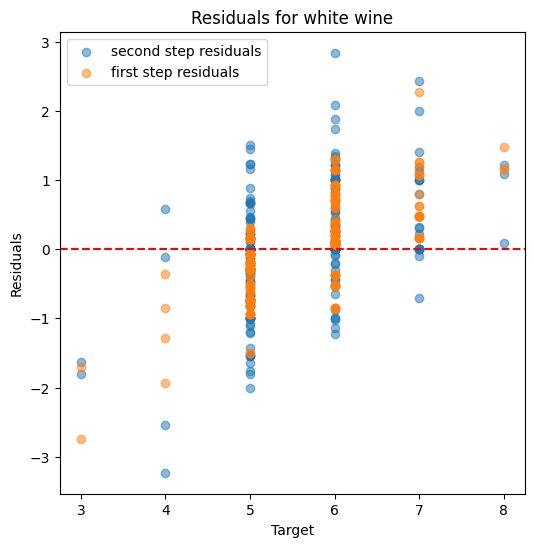

In [58]:
tree_white_1 = tree_white.best_estimator_.fit(X_white_train, y_white_train)
y_white_pred1 = tree_white_1.predict(X_white_val)
residuals1 = y_white_train - tree_white_1.predict(X_white_train)
tree_white_2 = DecisionTreeRegressor().fit(X_white_train, residuals1)
y_white_pred2 = tree_white_2.predict(X_white_val)
plt.figure(figsize=(6,6))
plt.scatter(y_white_val, y_white_val - y_white_pred1 - y_white_pred2, marker="o", alpha=0.5, label = 'second step residuals')
plt.scatter(y_white_val, y_white_val - y_white_pred, marker="o", alpha=0.5, label='first step residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Target')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals for white wine')
plt.show()

We note that most of the residuals have recentered, which tells us that it has indeed learned new information from the residuals and justifies the use of an iterative residual learner algorithm.


### Red Wine


In [59]:
params_xgb_red = {
    'eta' : [0.01,0.05,0.1,0.3,0.5,0.7],
    'n_estimators': [100, 200, 400, 800, 1200, 1600, 2000],
    'max_depth': [9,10,11,12,20,21,23,24,25,26]
}
params_xgb_red = {'eta': [0.1], 'max_depth': [24], 'n_estimators': [1200]}

In [60]:
xgb_red = CV(XGBRegressor(), X_red, y_red, params=params_xgb_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.463 for {'eta': 0.1, 'max_depth': 24, 'n_estimators': 1200}


In [61]:
params_cat_red = {
    'learning_rate' : [0.01,0.05,0.1,0.3,0.5,0.7],
    'iterations': [100, 200, 400, 800, 1200, 1600, 2000],
    'depth': [9,10,11,12,20,21,23,24,25,26],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS']
}
params_cat_red = {'bootstrap_type': ['Bernoulli'], 'depth': [11], 'iterations': [1200], 'learning_rate': [0.1]}

In [62]:
cat_red = CV(CatBoostRegressor(verbose=False), X_red, y_red, params=params_cat_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.498 for {'bootstrap_type': 'Bernoulli', 'depth': 11, 'iterations': 1200, 'learning_rate': 0.1}


### White Wine


In [63]:
params_xgb_white = {
    'eta' : [0.01,0.05,0.1,0.3,0.5,0.7],
    'n_estimators': [100, 200, 400, 800, 1200, 1600, 2000],
    'max_depth': [9,10,11,12,20,21,23,24,25,26]
}
params_xgb_white = {'eta': [0.1], 'max_depth': [11], 'n_estimators': [200]}

In [64]:
xgb_white = CV(XGBRegressor(), X_white, y_white, params=params_xgb_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.399 for {'eta': 0.1, 'max_depth': 11, 'n_estimators': 200}


In [65]:
params_cat_white = {
    'learning_rate' : [0.01,0.05,0.1,0.3,0.5,0.7],
    'iterations': [100, 200, 400, 800, 1200, 1600, 2000],
    'depth': [9,10,11,12,20,21,23,24,25,26],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS']
}
params_cat_white = {'bootstrap_type': ['Bernoulli'], 'depth': [11], 'iterations': [200], 'learning_rate': [0.1]}

In [66]:
cat_white = CV(CatBoostRegressor(verbose=False), X_white, y_white, params_cat_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.445 for {'bootstrap_type': 'Bernoulli', 'depth': 11, 'iterations': 200, 'learning_rate': 0.1}


The performance obtained with gradient boosting is very good. Ensemble methods seem to work well for this kind of very complex data.

# Neural Network


A neural network consists of a series of interconnected layers, each formed by multiple adapted weight combinations from the preceding layer. These combinations are activated by a function to introduce non-linearity, a key aspect that allows neural networks to act as universal approximators.


Despite the opacity of these models, their consistent accuracy across numerous cases makes us consider them in our models.

We acknowledge the potential for optimizing various parameters and exploring diverse architectures to suit different objectives. However, in this project, we focus on using the methods already implemented in the `MLPRegressor` model of Scikit-learn. This includes optimizing essential parameters like the number and size of layers, choice of optimizers, activation functions, the number of iterations, and strategies for learning rate optimization.

### Red Wine


In [67]:
param_mlp_red = {
    "hidden_layer_sizes":[[200], [600], [1000], [200,50], [20,20,20], [100,60,30]],
    "activation" : ['tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    "max_iter":[4000],
    "alpha":[0.00001, 0.0001, 0.001],
    "learning_rate" : ["constant", "adaptive"]
}
param_mlp_red = {'activation': ['relu'], 'alpha': [0.0001], 'hidden_layer_sizes': [[600]], 'learning_rate': ['constant'], 'max_iter': [4000], 'solver': ['adam']}

In [68]:
mlp_red = CV(MLPRegressor(), X_red, y_red, params=param_mlp_red)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.389 for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [600], 'learning_rate': 'constant', 'max_iter': 4000, 'solver': 'adam'}


### White Wine


In [69]:
param_mlp_white = {
    "hidden_layer_sizes":[[200], [600], [1000], [200,50], [20,20,20], [100,60,30]],
    "activation" : ['tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    "max_iter":[4000],
    "alpha":[0.00001, 0.0001, 0.001],
    "learning_rate" : ["constant", "adaptive"]
}
param_mlp_white = {'activation': ['relu'], 'alpha': [0.0001], 'hidden_layer_sizes': [[600]], 'learning_rate': ['constant'], 'max_iter': [4000], 'solver': ['adam']}

In [70]:
mlp_white = CV(MLPRegressor(), X_white, y_white, params=param_mlp_white)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best R² score is 0.331 for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [600], 'learning_rate': 'constant', 'max_iter': 4000, 'solver': 'adam'}


# A posteriori methods

After testing standard regression algorithms, we developed our own methods aimed at enhancing the final model's accuracy. Detailed in our report, these methods, termed $\textit{a posteriori}$ methods, operate on a different learning level than the previous standard approaches—acting as residual correctors in subsequent layers.

Our approach involved leveraging specialized methods that are able to learn particular interactions within the data. Our goal was to aggregate these diverse learnings into a unified final predictor. Initially, our intuition was to average all predictions to derive a single one. However, realizing the varied accuracy among predictors, we weighted the mean accordingly. This led to conceptualizing the predictors as feature mappings, each contributing to a one-dimensional space, with the model essentially computing a simple mean.

To improve this, we adopted more complex meta-aggregators capable of capturing intricate relationships, such as random forests or neural networks.

 We also expanded the discrete target space into a regression problem, introducing bias even in certain predictions we were confident about. To address this, we created a filter 

To mitigate the computational load resulting from the numerous learning layers, we have chosen to employ a hold-out principle to estimate accuracy. We acknowledge that this approach provides a generalization order conditioned to the dataset. However, in future work, if better computational resources are available, techniques like bootstrap or cross-validation (CV) could be considered to address this limitation.

In [71]:
X_red_train, X_red_val, y_red_train, y_red_val = train_test_split(X_red, y_red, test_size=0.3, random_state=seed)
X_white_train, X_white_val, y_white_train, y_white_val = train_test_split(X_white, y_white, test_size=0.3, random_state=seed)

## Aggregation

As explained in the introduction, we will aggregate the predictors initially in a naive weighted manner, and then employ a more complex approach with a meta-aggregator.

### WeightedAverage

In [72]:
class WeightedAverageRegressor():
    """
    Weighted average of predictions from different models.
    """
    def __init__(self, Models, weights=False):
        self.weights = self.Weights(Models) if weights else weights
        self.Models = Models.copy()

    def fit(self, X, y):
        """
        Fit the best estimator of each model grid on the whole training set.

        Args:
            X: Feature matrix.
            y: Target vector.
        
        Returns:
            self: self
        """
        for name, model in self.Models.items():
            #all models except GAM
            if hasattr(model, 'best_estimator_'):
                model.best_estimator_.fit(X, y)
            else:
                model.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict the target with the weighted average of predictions from different models.

        Args:
            X: Feature matrix.

        Returns:
            Y_pred: Predictions of the expert aggregation.
        """
        Y = self.Y_matrix(self.Models, X)
        if not self.weights:
            y = Y.mean(axis=1).rename('target')
        if self.weights:
            self.weights /= sum(self.weights)
            y = (Y*self.weights).sum(axis=1).rename('target')
        
        return y.to_frame()
        
    ####### Helper functions #######

    def Weights(self, Models):
        """
        Get the weight of each model.

        Args:
            Models: Dictionary of models grid {name, grid}.
            
        Returns:
            weights: List of weights.
        """
        weights = []
        for name, model in Models.items():
                #all models except GAM
                try:
                    #all models except GAM
                    if hasattr(model, 'best_score_'):
                        weights.append(model.best_score_)
                    #GAM model
                    else:
                        weights.append(model.statistics_['pseudo_r2']['McFadden_adj'])
                except:
                    print(f'Error with {name} to get its weight')
                    
        return weights

    def Y_matrix(self, Models, X):
        """
        Create a matrix of predictions for each model.

        Args:
            Models: Dictionary of models {name : model}.
            X: Feature matrix.

        Returns:
            Y: Matrix of predictions.
        """
        Y = pd.DataFrame()
        for name, model in Models.items():
            Y[name] = model.predict(X)
        Y.index = X.index
        return Y

#### Red Wine

In [73]:
models1_red = {
    'linear' : linear_red,
    #'gam' : gam_red,
    'svr' : svr_red,
    'tree' : tree_red,
    'rf' : rf_red,
    'xgb' : xgb_red,
    'cat' : cat_red,
    'mlp' : mlp_red
}
models2_red = {
    'rf' : rf_red,
    'xgb' : xgb_red,
    'cat' : cat_red,
}

In [74]:
pred_red_models1 = WeightedAverageRegressor(models1_red, weights=True).fit(X_red_train, y_red_train).predict(X_red_val)
score_red_models1 = r2_score(y_red_val, pred_red_models1)
print(f'Best R² score is \033[91m{score_red_models1:.3f}\033[0m for the weighted average of all models')

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Best R² score is 0.464 for the weighted average of all models


In [75]:
pred_red_models2 = WeightedAverageRegressor(models2_red, weights=True).fit(X_red_train, y_red_train).predict(X_red_val)
score_red_models2 = r2_score(y_red_val, pred_red_models2)
print(f'Best R² score is \033[91m{score_red_models2:.3f}\033[0m for the weighted average of best models')

Best R² score is 0.473 for the weighted average of best models


#### White wine

In [76]:
models1_white = {
    'linear' : linear_white,
    #'gam' : gam_white,
    'svr' : svr_white,
    'tree' : tree_white,
    'rf' : rf_white,
    'xgb' : xgb_white,
    'cat' : cat_white,
    'mlp' : mlp_white
}
models2_white = {
    'rf' : rf_white,
    'xgb' : xgb_white,
    'cat' : cat_white,
}

In [77]:
pred_white_models1 = WeightedAverageRegressor(models1_white, weights=True).fit(X_white_train, y_white_train).predict(X_white_val)
score_white_models1 = r2_score(y_white_val, pred_white_models1)
print(f'Best R² score is \033[91m{score_white_models1:.3f}\033[0m for the weighted average of all models')

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Best R² score is 0.427 for the weighted average of all models


In [78]:
pred_white_models2 = WeightedAverageRegressor(models2_white, weights=True).fit(X_white_train, y_white_train).predict(X_white_val)
score_white_models2 = r2_score(y_white_val, pred_white_models2)
print(f'Best R² score is \033[91m{score_white_models2:.3f}\033[0m for the weighted average of all models')

Best R² score is 0.429 for the weighted average of all models


### Meta Model

In [79]:
class MetaModelRegressor():
    
    def __init__(self, Models, seed=seed):
        self.Models = Models.copy()
        self.seed = seed
    
    def fit(self, meta_model, params, X, y, k_folds_level1=5, k_folds_level2=5, validation_size=0.35):
        """
        Train the meta model on the concatenation of validation set prediction and the initial features
            from the predictions of different models tunning by cross validation.

        Args:
            meta_model: The estimator or model to be tuned.
            params: Dictionary of hyperparameters to be tuned.
            X: Feature matrix.
            y: Target vector.
            k_folds_level1: Number of cross-validation folds for level-1 (default is 5).
            k_folds_level2: Number of cross-validation folds for level-2 (default is 5).
            validation_size: Size of the validation set (default is 0.35).
        """
        # Split the train into train + validation
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, random_state=self.seed)

        # Level-1 : Train models on the training set and predict on the validation set
        for name, model in self.Models.items():
            model['model'] = self.FitCV(model['model'], model['params'], X_train, y_train, k_folds_level1)
        Y_val = self.Y_matrix(self.Models, X_val)

        # Level-2 : Train the meta model on the concatenation of validation set  prediction and the initial features
        concat_val = pd.merge(Y_val, X_val, left_index=True, right_index=True, how='outer')
        meta_model = CV(meta_model, concat_val, y_val, params=params, k_folds=k_folds_level2).best_estimator_
        self.meta_model = meta_model

        return self

    def predict(self, X_test):
        """
        Predict the target with the meta model and the predictions from different models.

        Args:
            X_test: Feature matrix.
        
        Returns:
            y_pred: Predictions of the meta model.
        """
        # Level-1
        Y_test = self.Y_matrix(self.Models, X_test)

        # Level-2
        concat_test = pd.merge(Y_test, X_test, left_index=True, right_index=True, how='outer')
        y_pred = self.meta_model.predict(concat_test)
        
        return pd.DataFrame(y_pred, index=X_test.index, columns=['target'])

    ####### Helper functions #######

    def Y_matrix(self, Models, X):
        """
        Create a matrix of predictions for each model.

        Args:
            Models: Dictionary of models {name : model}.
            X: Feature matrix.

        Returns:
            Y: Matrix of predictions.
        """
        Y = pd.DataFrame()
        for name, model in Models.items():
            Y[name] = model['model'].predict(X)
        Y.index = X.index
        return Y

    def FitCV(self, model, params, X, y, k_folds):
        """
        Fit a model with cross validation (or not if model can't).

        Args:
            model: The estimator or model to be tuned.
            X: Feature matrix.
            y: Target vector.

        Returns:
            model: The fitted model.
        """
        try:
            model = CV(model, X, y, params, k_folds=k_folds).best_estimator_            
        except:
            model.fit(X, y)
        
        return model

#### Red Wine

In [80]:
models1_red = {
    'linear' : {'model' : LinearRegression(), 'params' : {'fit_intercept': [True]}},
    #'gam' : {'model' : LinearGAM(s(0)+s(1)+s(5)+s(6)+s(7)+l(9)+te(0,7)+te(1,3)+ te(3,10)+te(4,7)+te(5,6)+te(1,2)+te(4,10)+te(10,7)+te(8,7)+te(8,4)), 'params' : {}},
    'svr' : {'model' : SVR(), 'params' : params_SVR_red},
    'tree' : {'model' : DecisionTreeRegressor(), 'params' : params_tree_red},
    'rf' : {'model' : RandomForestRegressor(), 'params' : params_RF_red},
    'xgb' : {'model' : XGBRegressor(), 'params' : params_xgb_red},
    'cat' : {'model' : CatBoostRegressor(verbose=False), 'params' : params_cat_red},
    'mlp' : {'model' : MLPRegressor(), 'params' : param_mlp_red}
}
models2_red = {
    'rf' : {'model' : RandomForestRegressor(), 'params' : params_RF_red},
    'xgb' : {'model' : XGBRegressor(), 'params' : params_xgb_red},
    'cat' : {'model' : CatBoostRegressor(verbose=False), 'params' : params_cat_red},
}

In [81]:
params_meta_red = {
    'max_depth': range(1,20),
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [200, 400, 600, 800]
}
params_meta_red = {'max_depth': [13], 'max_features': ['sqrt'], 'n_estimators': [200]}

In [82]:
pred_red_models1 = MetaModelRegressor(models1_red).fit(RandomForestRegressor(), params_meta_red, X_red_train, y_red_train, k_folds_level1=1, k_folds_level2=5).predict(X_red_val)
score_red_models1 = r2_score(y_red_val, pred_red_models1)
print(f'Best R² score is \033[91m{score_red_models1:.3f}\033[0m for the meta model of all models')

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)
C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)
c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best R² score is 0.437 for {'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 200}
Best R² score is 0.449 for the meta model of all models


In [83]:
params_meta_red = {
    'max_depth': range(1,20),
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [200, 400, 600, 800]
}
params_meta_red = {'max_depth': [15], 'max_features': ['sqrt'],'n_estimators': [600]}

In [84]:
pred_red_models2 = MetaModelRegressor(models2_red).fit(RandomForestRegressor(), params_meta_red, X_red_train, y_red_train, k_folds_level1=1, k_folds_level2=5).predict(X_red_val)
score_red_models2 = r2_score(y_red_val, pred_red_models2)
print(f'Best R² score is \033[91m{score_red_models2:.3f}\033[0m for the meta model of best models')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best R² score is 0.438 for {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 600}
Best R² score is 0.441 for the meta model of best models


#### White wine

In [85]:
models1_white = {
    'linear' : {'model' : LinearRegression(), 'params' : {'fit_intercept': [True]}},
    #'gam' : {'model' : LinearGAM(s(0)+s(1)+s(5)+s(6)+s(7)+l(9)+te(0,7)+te(1,3)+ te(3,10)+te(4,7)+te(5,6)+te(1,2)+te(4,10)+te(10,7)+te(8,7)+te(8,4)), 'params' : {}},
    'svr' : {'model' : SVR(), 'params' : params_SVR_white},
    'tree' : {'model' : DecisionTreeRegressor(), 'params' : params_tree_white},
    'rf' : {'model' : RandomForestRegressor(), 'params' : params_RF_white},
    'xgb' : {'model' : XGBRegressor(), 'params' : params_xgb_white},
    'cat' : {'model' : CatBoostRegressor(verbose=False), 'params' : params_cat_white},
    'mlp' : {'model' : MLPRegressor(), 'params' : param_mlp_white}
}
models2_white = {
    'rf' : {'model' : RandomForestRegressor(), 'params' : params_RF_white},
    'xgb' : {'model' : XGBRegressor(), 'params' : params_xgb_white},
    'cat' : {'model' : CatBoostRegressor(verbose=False), 'params' : params_cat_white},
}

In [86]:
params_meta_white = {
    'max_depth': range(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [200, 400, 800, 1000, 1200, 1400, 1600]
}
params_meta_white = {'max_depth': [3], 'max_features': ['sqrt'], 'n_estimators': [1400]}

In [87]:
pred_white_models1 = MetaModelRegressor(models1_white).fit(RandomForestRegressor(), params_meta_white, X_white_train, y_white_train, k_folds_level1=1, k_folds_level2=5).predict(X_white_val)
score_white_models1 = r2_score(y_white_val, pred_white_models1)
print(f'Best R² score is \033[91m{score_white_models1:.3f}\033[0m for the meta model of all models')

C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)
C:\Users\lucas\AppData\Local\Temp\ipykernel_15880\818730543.py:19: Warning: Random seed could not be set.
  warnings.warn("Random seed could not be set.", category=Warning)
c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best R² score is 0.375 for {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1400}
Best R² score is 0.393 for the meta model of all models


In [88]:
params_meta_white = {
    'max_depth': range(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [200, 400, 800, 1000]
}
params_meta_white = {'max_depth': [4],'max_features': ['sqrt'],'n_estimators': [1000]}

In [89]:
pred_white_models2 = MetaModelRegressor(models2_white).fit(RandomForestRegressor(), params_meta_white, X_white_train, y_white_train, k_folds_level1=1, k_folds_level2=5).predict(X_white_val)
score_white_models2 = r2_score(y_white_val, pred_white_models2)
print(f'Best R² score is \033[91m{score_white_models2:.3f}\033[0m for the meta model of best models')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best R² score is 0.390 for {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 1000}
Best R² score is 0.385 for the meta model of best models


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


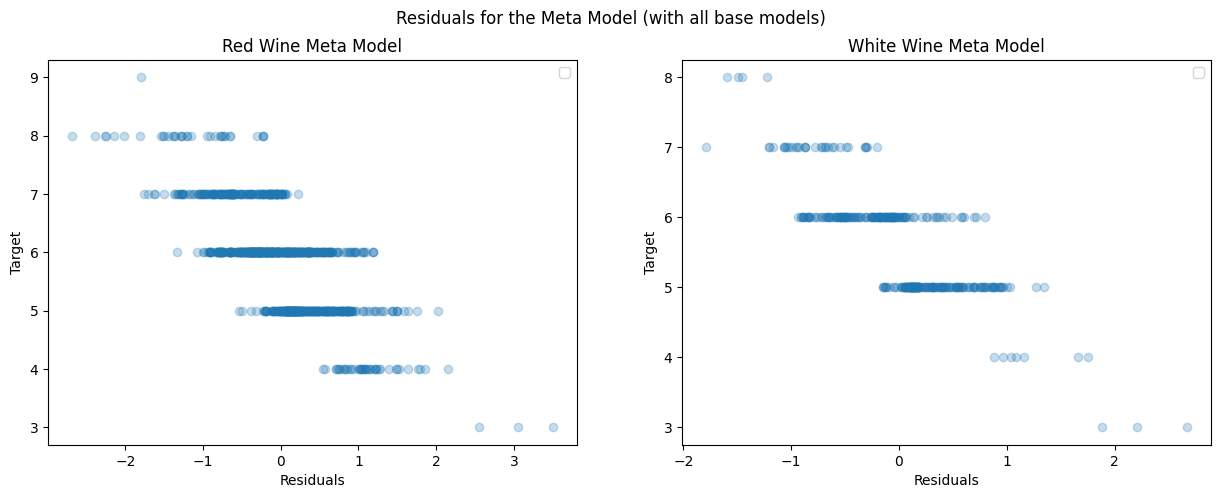

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(pred_red_models1 - pd.DataFrame(y_red_val), y_red_val, marker="o", alpha=0.25)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Target')
ax1.set_title('Red Wine Meta Model')
ax2.scatter(pred_white_models1 - pd.DataFrame(y_white_val), y_white_val, marker="o", alpha=0.25)
ax2.set_title('White Wine Meta Model')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Target')
ax1.legend()
ax2.legend()
fig.suptitle('Residuals for the Meta Model (with all base models)')
plt.show()

## Student's filter

Finally, we attempt to address the bias introduced by treating the label as continuous while it is discrete. To begin, we test the normality of the residuals conditioned on a label using the Shapiro-Wilk test. Should the test confirm normality, we can construct a Student's distribution from the data and estimate confident intervals for classification.

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best R² score is 0.454 for {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 92 candidates, totalling 460 fits
Best R² score is 0.411 for {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


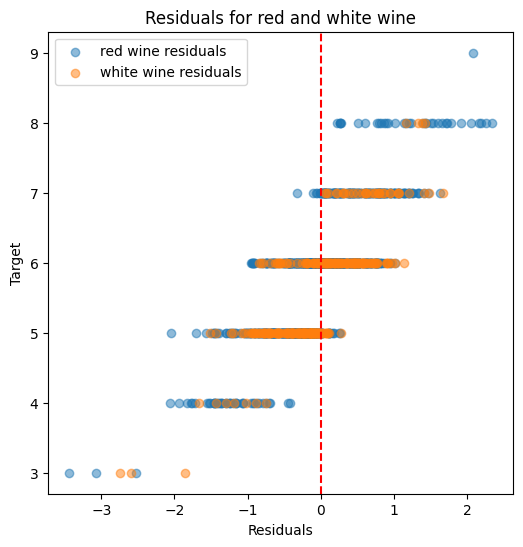

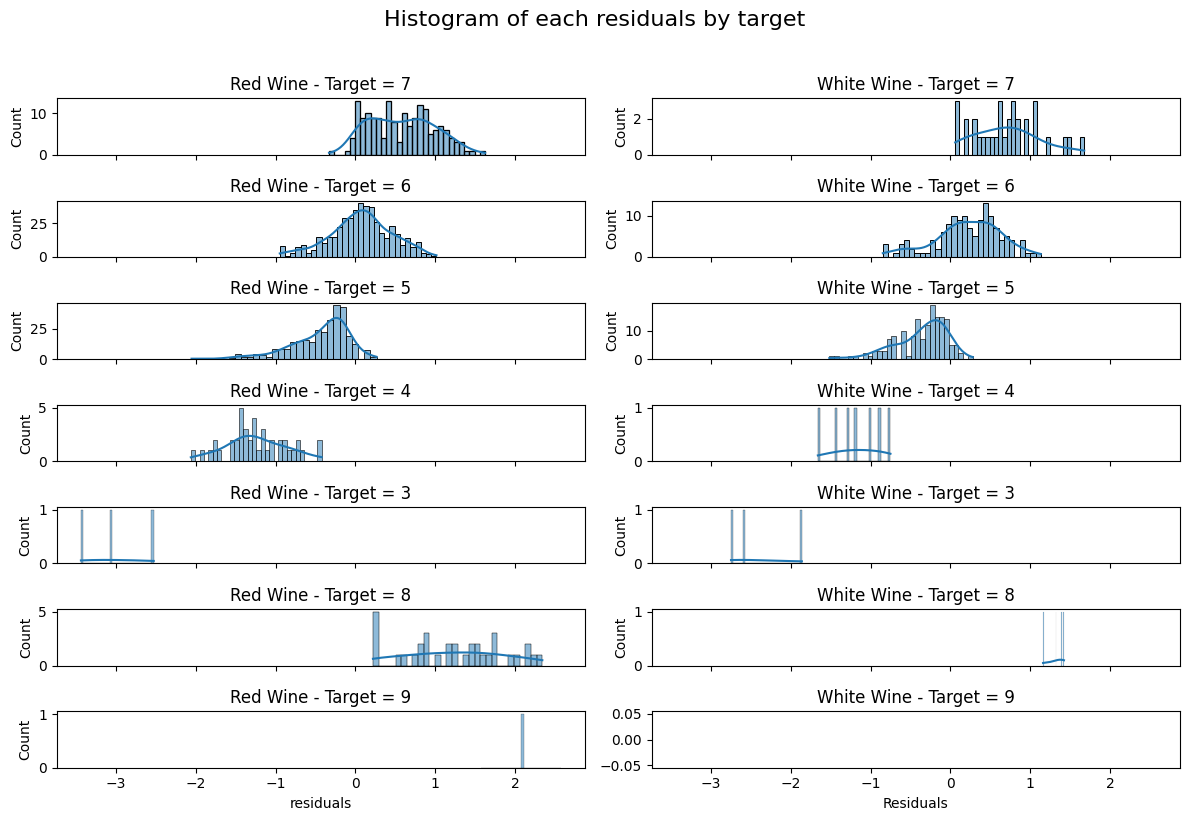

In [91]:
rf2_red = CV(RandomForestRegressor(criterion='squared_error'), X_red_train, y_red_train, params={'n_estimators': [100, 200], 'max_depth': range(17,24), 'min_samples_split': [2], 'max_features': ['sqrt', 'log2']}, k_folds=5)
rf2_white = CV(RandomForestRegressor(criterion='squared_error'), X_white_train, y_white_train, params={'n_estimators': [100, 200], 'max_depth': range(2,25), 'min_samples_split': [2], 'max_features': ['sqrt', 'log2']}, k_folds=5)
residuals_red = y_red_val - rf2_red.best_estimator_.predict(X_red_val)
residuals_white = y_white_val - rf2_white.best_estimator_.predict(X_white_val)

# Residuals for red and white wine
plt.figure(figsize=(6,6))
plt.scatter(residuals_red, y_red_val, marker="o", alpha=0.5, label = 'red wine residuals')
plt.scatter(residuals_white, y_white_val,marker="o", alpha=0.5, label='white wine residuals')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Target')
plt.legend()
plt.title('Residuals for red and white wine')
plt.show()

df_red_wine = pd.DataFrame({'residuals': residuals_red, 'y': y_red_val})
df_white_wine = pd.DataFrame({'residuals': residuals_white, 'y': y_white_val})

fig, axes = plt.subplots(nrows=len(df_red_wine['y'].unique()), ncols=2, figsize=(12, 8), sharex=True)
for idx, value in enumerate(df_red_wine['y'].unique()):
    group_red_wine = df_red_wine[df_red_wine['y'] == value]
    group_white_wine = df_white_wine[df_white_wine['y'] == value]
    sns.histplot(data=group_red_wine, x='residuals', ax=axes[idx, 0], bins=30, kde=True)
    axes[idx, 0].set_title(f'Red Wine - Target = {value}')
    sns.histplot(data=group_white_wine, x='residuals', ax=axes[idx, 1], bins=30, kde=True)
    axes[idx, 1].set_title(f'White Wine - Target = {value}')
fig.suptitle('Histogram of each residuals by target', y=1.02, fontsize=16)
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

In [92]:
class Filter():
    def __init__(self):
        pass

    def fit(self, y, y_pred, threshold_shapiro, threshold_ttest, k_folds=4):
        """
        Filter the target vector thanks to Shapiro-Wilk and t tests.

        Args:
            y: Target vector (Dataframe, not Series).
            y_pred: Predictions of the target (Dataframe, not Series).
            threshold_shapiro: Threshold for the p-value of the Shapiro-Wilk test (default is 0.05).
            threshold_ttest: Threshold for the p-value of the t-test (default is 0.05).

        Returns:
            y_output: Filtered target vector.
        """
        best_filter, best_score, best_threshold_shapiro, best_threshold_ttest = None, 0, 0, 0
        for alpha in threshold_shapiro:
            for beta in threshold_ttest:
                folds_pred, folds_targets = self.Folds(y_pred, y, k_folds)
                for i in range(k_folds):
                    # Training set
                    training_pred = pd.concat([folds_pred[j] for j in range(k_folds) if j != i])
                    training_targets = pd.concat([folds_targets[j] for j in range(k_folds) if j != i])
                    # Create subsets
                    y_subsets = self.Subsets(training_pred, training_targets)
                    # Create boundaries
                    self.boundaries = self.Boundaries(y_subsets, y, alpha, beta)

                    # Validation set
                    val_pred = folds_pred[i]
                    val_targets = folds_targets[i]
                    # Filter the validation set
                    val_pred_filtered = self.apply(val_pred)
                    # Compute the R² score
                    score = r2_score(val_targets, val_pred_filtered)

                    if score > best_score:
                        best_score = score
                        best_threshold_shapiro = alpha
                        best_threshold_ttest = beta
                        best_filter = self.boundaries

        self.boundaries = best_filter
        
        print(f'Best R² score is \033[91m{best_score:.3f}\033[0m for a Shapiro-Wilk p-value threshold of \033[91m{best_threshold_shapiro:.3f}\033[0m and a t-test p-value threshold of \033[91m{best_threshold_ttest:.3f}\033[0m')

        return self

    def apply(self, y):
        """
        Apply the filter to the target vector.

        Args:
            y: Target vector.
            boundaries: List of boundaries.

        Returns:
            y_output: Filtered target vector.
        """
        y_output = y.copy()
        for boundary in self.boundaries:
            y_output['target'].loc[(y_output['target'] >= boundary[0][0]) & (y_output['target'] <= boundary[0][1])] = boundary[1]
        return y_output

    ####### Helper functions #######

    def Folds(self, X, y, k_folds):
        """
        Split the dataset into k folds with a random shuffle.

        Args:
            X: Feature matrix.
            y: Target vector.
            k_folds: Number of folds.

        Returns:
            folds_data: List of feature matrix for each fold.
            folds_targets: List of target vector for each fold.
        """
        ind = list(X.index)
        np.random.shuffle(ind) #seed parameter anvailable
        X = X.loc[ind]
        y = y.loc[ind]


        fold_size = len(X) // k_folds
        folds_data = [X.iloc[i * fold_size: (i + 1) * fold_size] for i in range(k_folds)]
        folds_targets = [y.iloc[i * fold_size: (i + 1) * fold_size] for i in range(k_folds)]

        return folds_data, folds_targets

    def Subsets (self, y_pred, y):
        """
        Create subsets of y_pred for each target.

        Args:
            y: Target vector.
            y_pred: Predictions of the expert aggregation.

        Returns:
            y_subsets: List of subsets.
        """
        y_subsets = []
        for target in y['target'].unique():
            y_subsets.append(y_pred[y == target].dropna())   

        return y_subsets

    def Boundaries (self, y_subsets, y, threshold_shapiro, threshold_ttest):
        """
        Create boundaries for each subset.

        Args:
            y: Target vector.
            y_subsets: List of subsets.
            threshold_shapiro: Threshold for the p-value of the Shapiro-Wilk test.
            threshold_ttest: Threshold for the p-value of the t-test.

        Returns:
            boundaries: List of boundaries.
        """
        # Create boundaries with Shapiro-Wilk and t tests quantiles
        boundaries = []
        for subset in y_subsets:
            if len(subset)>3 and shapiro(subset)[1] > threshold_shapiro: #3 because shapiro() need at least 3 values
                quantile_t = t.ppf(1 - threshold_ttest / 2, len(subset)-1)
                lower_bound = subset.mean() - quantile_t*subset.var()/np.sqrt(len(subset))
                upper_bound = subset.mean() + quantile_t*subset.var()/np.sqrt(len(subset))
                boundaries.append(([lower_bound[0], upper_bound[0]], y.loc[subset.index[0]][0]))
        if len(boundaries) == 0:
            return boundaries

        # Sort boundaries based on the lower bound
        boundaries.sort(key=lambda x: x[0][0])

        # Remove boundaries that include others 
        for i in range(len(boundaries)-1):
            for j in range(i+1, len(boundaries)-1):
                # check if the bundaries i is included in the boundaries j
                if boundaries[i][0][0] > boundaries[j][0][0] and boundaries[i][0][1] < boundaries[j][0][1]:
                    boundaries.remove(boundaries[j])
                # check if the bundaries j is included in the boundaries i
                elif boundaries[i][0][0] < boundaries[j][0][0] and boundaries[i][0][1] > boundaries[j][0][1]:
                    boundaries.remove(boundaries[i])
        
        # Adjust boundaries based on the intersection rule
        for i in range(len(boundaries)-1):
            if boundaries[i][0][1] > boundaries[i+1][0][0]:
                boundaries[i][0][1], boundaries[i+1][0][0] = boundaries[i+1][0][0], boundaries[i][0][1]
        
        return boundaries

#### Red Wine

In [93]:
y_red_pred = RandomForestRegressor(max_depth=23, max_features='sqrt', n_estimators=700).fit(X_red_train, y_red_train).predict(X_red_val)
y_red_pred = pd.DataFrame(y_red_pred, index=y_red_val.index, columns=['target'])
y_red_val = pd.DataFrame(y_red_val, index=y_red_val.index, columns=['target'])

In [94]:
filter_red = Filter().fit(y_red_val, y_red_pred , threshold_shapiro=[0.05, 0.1, 0.2, 0.5, 0.7], threshold_ttest=[0.05, 0.1, 0.2, 0.5, 0.7, 0.8], k_folds=10)
score_filter_red = r2_score(y_red_val, filter_red.apply(y_red_pred))
print(f'Best R² score is \033[91m{score_filter_red:.3f}\033[0m for the filtered target vector')

Best R² score is 0.597 for a Shapiro-Wilk p-value threshold of 0.050 and a t-test p-value threshold of 0.800
Best R² score is 0.428 for the filtered target vector


#### White Wine

In [95]:
y_white_pred = RandomForestRegressor(max_depth=19, max_features='sqrt', n_estimators=800).fit(X_white_train, y_white_train).predict(X_white_val)
y_white_pred = pd.DataFrame(y_white_pred, index=y_white_val.index, columns=['target'])
y_white_val = pd.DataFrame(y_white_val, index=y_white_val.index, columns=['target'])

In [96]:
filter_white = Filter().fit(y_white_val, y_white_pred , threshold_shapiro=[0.05, 0.1, 0.2, 0.5, 0.7], threshold_ttest=[0.05, 0.1, 0.2, 0.5, 0.7, 0.8], k_folds=10)
score_filter_white = r2_score(y_white_val, filter_white.apply(y_white_pred))

Best R² score is 0.678 for a Shapiro-Wilk p-value threshold of 0.700 and a t-test p-value threshold of 0.700
